In [1]:
%load_ext autoreload
%autoreload 2


In [ ]:
import argparse
import colorsys
import os
import random
import re

import matplotlib as mpl
import matplotlib.animation as mplanim
import matplotlib.pyplot as plt
import matplotlib.transforms as mpltrans
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import torch
from tqdm import tqdm
import umap

import celltrip


os.environ['AWS_PROFILE'] = 'waisman-admin'


In [3]:
# Arguments # TODO REPLACE
parser = argparse.ArgumentParser(description='Train CellTRIP model', formatter_class=argparse.ArgumentDefaultsHelpFormatter)

# Reading
group = parser.add_argument_group('Input')
group.add_argument('input_files', type=str, nargs='*', help='h5ad files to be used for input')
group.add_argument('--merge_files', type=str, action='append', nargs='+', help='h5ad files to merge as input')
group.add_argument('--partition_cols', type=str, action='append', nargs='+', help='Columns for data partitioning, found in `adata.obs` DataFrame')
group.add_argument('--backed', action='store_true', help='Read data directly from disk or s3, saving memory at the cost of time')
group.add_argument('--input_modalities', type=int, nargs='+', help='Input modalities to give to CellTRIP')
group.add_argument('--target_modalities', type=int, nargs='+', help='Target modalities to emulate, dictates environment reward')
# Computation
group = parser.add_argument_group('Computation')
group.add_argument('--num_gpus', type=int, default=1, help='Number of GPUs to use during computation')
group.add_argument('--num_learners', type=int, default=1, help='Number of learners used in backward computation, cannot exceed GPUs')
group.add_argument('--num_runners', type=int, default=1, help='Number of workers for environment simulation')
# Training
group = parser.add_argument_group('Training')
group.add_argument('--steps', type=int, default=int(5e3), help='Number of steps recorded before each update')
group.add_argument('--max_updates', type=int, default=200, help='Maximum number of policy updates to compute before exiting')
group.add_argument('--dont_sync_across_nodes', action='store_true', help='Avoid memory sync across nodes, saving overhead time at the cost of stability')
# File saves
group = parser.add_argument_group('Logging')
group.add_argument('--logfile', type=str, default='cli', help='Location for log file, can be `cli`, `<local_file>`, or `<s3 location>`')
group.add_argument('--flush_iterations', type=int, help='Number of iterations to wait before flushing logs')
group.add_argument('--checkpoint', type=str, help='Checkpoint to use for initializing model')
group.add_argument('--checkpoint_iterations', type=int, default=20, help='Number of iterations to wait before recording checkpoints')
group.add_argument('--checkpoint_dir', type=str, default='./checkpoints', help='Directory for checkpoints')
group.add_argument('--checkpoint_name', type=str, help='Run name, for checkpointing')

# Notebook defaults and script handling
if not celltrip.utility.notebook.is_notebook():
    # ray job submit -- python train.py...
    config = parser.parse_args()
else:
    experiment_name = '3gpu-new-arch-3-2k'
    command = (
        f's3://nkalafut-celltrip/MERFISH/expression.h5ad s3://nkalafut-celltrip/MERFISH/spatial.h5ad '
        # f'/home/nck/repos/INEPT/data/MERFISH/expression.h5ad /home/nck/repos/INEPT/data/MERFISH/spatial.h5ad '
        f'--backed '
        f'--target_modalities 1 '
        f'--num_gpus 2 --num_learners 2 --num_runners 4 '
        f'--steps 5000 '
        f'--max_updates 50 '
        f'--dont_sync_across_nodes '
        f'--logfile s3://nkalafut-celltrip/logs/{experiment_name}.log '
        f'--checkpoint_dir s3://nkalafut-celltrip/checkpoints '
        f'--checkpoint_name {experiment_name}')
    config = parser.parse_args(command.split(' '))
    print(f'python train.py {command}')
    
# Defaults
if config.checkpoint_name is None:
    config.checkpoint_name = f'RUN_{random.randint(0, 2**32):0>10}'
    print(f'Run Name: {config.checkpoint_name}')
# print(config)  # CLI


python train.py s3://nkalafut-celltrip/MERFISH/expression.h5ad s3://nkalafut-celltrip/MERFISH/spatial.h5ad --backed --target_modalities 1 --num_gpus 2 --num_learners 2 --num_runners 4 --steps 5000 --max_updates 50 --dont_sync_across_nodes --logfile s3://nkalafut-celltrip/logs/3gpu-new-arch-3-2k.log --checkpoint_dir s3://nkalafut-celltrip/checkpoints --checkpoint_name 3gpu-new-arch-3-2k


In [4]:
# import s3fs
# s3 = s3fs.S3FileSystem()
# s3.ls('s3://nkalafut-celltrip/checkpoints')


In [5]:
torch.random.manual_seed(42)
np.random.seed(42)

# Initialize locally
os.environ['AWS_PROFILE'] = 'waisman-admin'
dataloader_kwargs = {}  # {'num_nodes': 2000, 'pca_dim': 256}
environment_kwargs = {
    'input_modalities': config.input_modalities,
    'target_modalities': config.target_modalities, 'dim': 3}
env_init, policy_init, memory_init = celltrip.train.get_initializers(
    input_files=config.input_files, merge_files=config.merge_files,
    backed=config.backed, # policy_kwargs={'minibatch_size': 2_000},
    dataloader_kwargs=dataloader_kwargs,
    environment_kwargs=environment_kwargs)
env = env_init().to('cuda')
policy = policy_init(env).to('cuda')
policy.load_checkpoint('s3://nkalafut-celltrip/checkpoints/3gpu-new-arch-10-norms-log-0200.weights')
policy = policy.eval()
# policy.actor_critic.log_std.data = torch.tensor(-2., device=policy.policy_iteration.device)


/home/thema/repos/inept/celltrip/utility/processing.py:109: RuntimeWarning: Modality 0 too small for PCA (253 features), skipping
  warnings.warn(
/home/thema/repos/inept/celltrip/utility/processing.py:109: RuntimeWarning: Modality 1 too small for PCA (2 features), skipping
  warnings.warn(


In [6]:
# ENV DISTANCE SHOULD BE BASED ON THE TRUE DATA!!!!!! Somehow and maybe


In [7]:
env.reset()
memory = memory_init(policy)
ret = celltrip.train.simulate_until_completion(env, policy, memory, keys=env.keys, store_states=True)
rewards = ret[:3]
states = ret[-1].cpu()
del ret
rewards


(1000,
 6868.72802734375,
 {'distance': 6994.765625,
  'origin': 0.0,
  'bound': 0.0,
  'velocity': -24.604978561401367,
  'action': -101.4355239868164})

In [8]:
(1000,
 6868.22705078125,
 {'distance': 6989.93017578125,
  'origin': 0.0,
  'bound': 0.0,
  'velocity': -25.081708908081055,
  'action': -96.61222076416016})


(1000,
 6868.22705078125,
 {'distance': 6989.93017578125,
  'origin': 0.0,
  'bound': 0.0,
  'velocity': -25.081708908081055,
  'action': -96.61222076416016})

In [9]:
# Our result
print(env.get_distance_match().mean())

# Random
env.reset()
print(env.get_distance_match().mean())
# 35

# Perfect
pos = torch.tensor(env.dataloader.adatas[1].X[:])
pos = torch.cat((pos, torch.zeros((pos.shape[0], 1))), dim=1).cuda()
pos = env.dist[1].max() * pos / torch.cdist(pos, pos).max()
env.pos = pos
env.reset_cache()
print(env.get_distance_match().mean())
# .0084


tensor(0.0536, device='cuda:0')
tensor(34.7792, device='cuda:0')
tensor(0.0084, device='cuda:0', dtype=torch.float64)


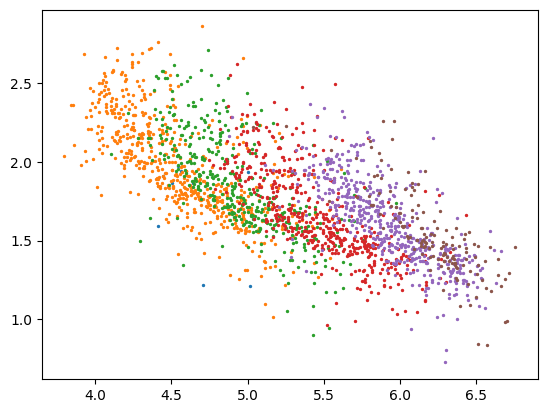

In [ ]:
# Get data and types
reducer = umap.UMAP()  # random_state=42
# raw = env.dataloader.adatas[0][env.keys].X
raw = states[-1, :, :env.dim]

# Transform
transformed = reducer.fit_transform(raw)
# transformed = raw[:, :2]
types = env.dataloader.adatas[0].obs.loc[env.keys, 'layer'].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(3, 3))
for t in np.unique(types):
    ax.scatter(*transformed[types==t].T, s=2)
sns.despine(ax=ax)
fig.show()


In [ ]:
# MESS WITH THIS LATER, GET IMGUI-BUNDLE INSTALLED
# import fastplotlib as fpl

# figure = fpl.Figure(cameras='3d', size=(600, 400), canvas_kwargs={'max_fps': 100})
# frame = 0
# scatter = figure[0, 0].add_scatter(
#     states[frame, :, :3],
#     cmap='Set1', cmap_transform=np.unique(types, return_inverse=True)[1])
# means = states.mean(keepdims=True, dim=1)

# def update():
#     global frame
#     frame += 1
#     scatter.data = states[frame, :, :3] - means[frame, :, :3]  # Replace this once model is retrained
#     if frame == states.shape[0] - 1: frame = -1

# figure[0, 0].add_animations(update)
# figure.show()


In [12]:
# fig, ax = plt.subplots()
# scatter = ax.scatter([], [])
# ax.set_xlim(-env.pos_bound, env.pos_bound)
# ax.set_ylim(-env.pos_bound, env.pos_bound)

# def animate(frame):
#     scatter.set_offsets(states[10*frame, :, :2])
#     return scatter,

# # Show animation
# ani = mplanim.FuncAnimation(fig, animate, frames=int(states.shape[0]/10), interval=20, blit=True)
# from IPython.display import HTML
# HTML(ani.to_jshtml())


In [ ]:
def center_states(states):
    states = states.copy()
    states[:, :, :env.dim] -= states[:, :, :env.dim].mean(keepdims=True, axis=1)
    return states


In [ ]:
def test_knockdown(modality, features, factor=0):
    # Set up env
    env.reset_cache()  # TODO: Add option to not calculate rewards
    env.vel_threshold = 5e-2  # TODO: FIX VEL AND ACTION REWARD SCALES SO THIS CAN BE MORE EFFECTIVE
    env.set_termination_conds(time=False, velocity=True)
    env.set_positions(states[-1, :, :env.dim].to(env.device))
    env.set_velocities(states[-1, :, env.dim:].to(env.device))
    # Knock down feature
    adatas, adata_obs, adata_vars = env.dataloader.get_transformables()
    iso_modality = env.dataloader.preprocessing.transform(
        adatas[modality][env.keys].X,
        subset_features=features,
        subset_modality=modality)[0]
    iso_modality = torch.tensor(iso_modality).to(env.device)
    env.modalities[modality] -= iso_modality - factor*iso_modality
    # Simulate
    ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
    # Reset
    env.modalities[modality] += iso_modality - factor*iso_modality
    return ret[3].cpu().numpy()  # States

env.reset()  # TODO: Allow for particular partition or not changing data
modality_to_test = 0
knocked_states = [
    test_knockdown(modality_to_test, feature)
    for feature in tqdm(range(env.get_modalities()[modality_to_test].shape[1]))]
knocked_states = [center_states(states) for states in knocked_states]  # TODO: FIX MODEL AS ABOVE


In [222]:
# Genes associated with 'neuron migration' (https://amigo.geneontology.org/amigo/search/bioentity?q=*%3A*&fq=isa_partof_closure:%22GO%3A0001764%22&sfq=document_category:%22bioentity%22)
gene_lists = {}
gene_lists['Neuron Migration'] = ['DCDC2', 'TUBB', 'ASTN2', 'DCC', 'KIAA0319L', 'ASTN2', 'DCC', 'SDCCAG8', 'FNDC1', 'ABI3', 'abi2', 'ASTN2', 'ABI1', 'ASTN2', 'KIAA0319', 'astn1.L', 'dab1.L', 'DCC', 'RELN', 'NEO1', 'DCDC2', 'NEO1', 'SDCCAG8', 'kiaa0319l.S', 'ABI2', 'LOC108700444', 'abi3.L', 'kiaa0319.S', 'NEMVEDRAFT_v1g148795', 'dcdc2.L', 'A0A7M7PLG8', 'NEMVEDRAFT_v1g99701', 'ABI1', 'astn1.S', 'LOC108699478', 'NEMVEDRAFT_v1g201627', 'NEO1', 'DCDC2', 'NEMVEDRAFT_v1g19347', 'NEMVEDRAFT_v1g241205', '1278655', 'AUGUSTUS-3.0.2_31053', 'AUGUSTUS-3.0.2_04237', 'ASTN1', 'neo1', 'TRIADDRAFT_28661', 'TRIADDRAFT_53937', 'ASTN2', 'LOC108698296', 'TUBB2B', 'abi1.S', 'KIAA0319', 'ABI1', 'TRIADDRAFT_57221', 'VEGFA', 'VEGFA', 'POMGNT2', 'pomgnt2', 'pomgnt2', 'SEPTIN4', 'SPOCK1', 'SPOCK1', 'SEPTIN4', 'SPOCK1', 'SPOCK1', 'DNAAF4', 'Q5ISK2', 'LHX1', 'LHX1', 'Lhx1', 'CCK', 'DNAAF4', 'TUBGCP2', 'FYN', 'DNAAF4', 'DNAAF4', 'RAC1', 'Q6PVU4', 'VEGFA', 'FGF13', 'GPM6A', 'G1N7F0', 'VEGFA', 'SH3RF1', 'CCK', 'SPOCK1', 'NRCAM', 'ASCL1', 'PEX5', 'CRK', 'neo1a', 'cxcr4b', 'kiaa0319', 'neo1b', 'rest', 'dab1a', 'abi3b', 'prickle1a', 'abi1a', 'ackr3b', 'trim46a', 'nhsl1b', 'nav1a', 'cxcl12b', 'egl-20', 'tbx-2', 'olig2', 'hgfb', 'hgfa', 'met', 'vangl2', 'kiaa0319l', 'cxcl12a', 'pbx4', 'abi2a', 'astn1', 'dab1b', 'sh3rf1', 'abi1b', 'scrib', 'hdac1', 'sdccag8', 'abi2b', 'prickle1b', 'nav1b', 'sax-3', 'rac-2', 'ptp-3', 'KIAA0319L', 'fgf13.L', 'abi1', 'dab1', 'sdccag8', 'pomgnt2.L', 'pomgnt2', 'abi2', 'kiaa0319', 'dcdc2', 'sh3rf1.S', 'nid-1', 'slt-1', 'nav1', 'cle-1', 'C34F6.10', 'cwn-1', 'cwn-2', 'Rac1', 'dcx.S', 'dcx.L', 'lhx1a', 'cdh2', 'reln', 'ndnf', 'ctnnd2b', 'abi3a', 'lama1', 'trim46b', 'supt5h', 'dcc', 'cdh1', 'disc1', 'dcc', 'BAX', 'GFRA3', 'MARK1', 'SH3RF1', 'POU4F1', 'TUBB2B', 'MARK2', 'SRF', 'YWHAE', 'ABI3', 'VEGFA', 'PTK2B', 'EVX1', 'GPM6A', 'LHX1', 'PLXNA1', 'RAC1', 'PEX13', 'DCX', 'UNK', 'PSEN1', 'TLX3', 'DRGX', 'TBX20', 'POU4F1', 'GATA3', 'DISC1', 'NDEL1', 'DCX', 'GAS6', 'PCM1', 'NDNF', 'TOP2B', 'NEUROD4', 'CNTN2', 'BBS1', 'ASTN2', 'DRGX', 'RAPGEF2', 'CRKL', 'CTNNB1', 'TRIM46', 'FZD3', 'ACAP3', 'LHX1', 'APBB2', 'PITX2', 'FEZF2', 'ELP3', 'BARHL2', 'CCKAR', 'FBXO45', 'CELSR1', 'BAX', 'APBB2', 'KIAA0319', 'RELN', 'ASTN1', 'KIAA0319L', 'SEMA3E', 'EMX2', 'PSEN1', 'CCR4', 'NDN', 'A0A8I3NGQ0', 'VEGFA', 'ASCL1', 'TWIST1', 'ALKBH1', 'WASF2', 'SRF', 'CHL1', 'ZMIZ1', 'ITGA3', 'TLX3', 'RAPGEF2', 'NR2F2', 'CEP85L', 'ACAP3', 'WASF2', 'NDNF', 'PLXNA3', 'NTN1', 'TUBA1A', 'RELN', 'ALKBH1', 'FKRP', 'CELSR2', 'CCR4', 'PEX5', 'DRD2', 'SEMA3E', 'TWIST1', 'ATOH1', 'SH3RF1', 'LRP12', 'MYH10', 'DAB1', 'SEMA3A', 'SEPTIN4', 'EMX2', 'FBXO45', 'KIAA0319', 'CCKAR', 'KIAA0319L', 'MATN2', 'GAS6', 'POMGNT2', 'NR4A2', 'POU4F1', 'FBXO41', 'SRF', 'ELP3', 'NTRK2', 'FOXG1', 'TYRO3', 'KIRREL3', 'NRP2', 'EVX1', 'BARHL2', 'RAPGEF2', 'ROBO3', 'CCK', 'MRTFA', 'DRGX', 'CELSR1', 'FILIP1', 'MDGA1', 'CNTN2', 'TOP2B', 'NDN', 'ELP3', 'A0AAF6ZA83', 'NEUROD4', 'PHOX2B', 'ASTN1', 'ARX', 'CRKL', 'TBX20', 'PLXNA1', 'BARHL1', 'DCC', 'FEZF1', 'VAX1', 'BBS1', 'POMGNT2', 'PCM1', 'NDEL1', 'PTK2B', 'DCX', 'TRIM46', 'CDK5R2', 'RHOA', 'CNTN2', 'FYN', 'FAT3', 'CDK5R2', 'RELN', 'ASPM', 'LHX1', 'DCDC2', 'CTNNB1', 'LHX1', 'CEP85L', 'FGF13', 'PCM1', 'FBXO41', 'ACAP3', 'NDNF', 'PSEN1', 'DISC1', 'MKL1', 'ARX', 'TWIST1', 'CCK', 'PAFAH1B1', 'OLIG3', 'PEX13', 'TBX20', 'TOP2B', 'FEZF1', 'CCK1R', 'FZD3', 'MYH10', 'MDGA1', 'POMGNT2', 'PHOX2B', 'BARHL2', 'RAC1', 'NR2F2', 'PRKG1', 'FYN', 'GFRA3', 'ASTN1', 'ASTN2', 'GPM6A', 'GFRA3', 'KIAA0319', 'CDK5R1', 'VEGFA', 'PEX13', 'MATN2', 'CDK5', 'SEPTIN14', 'FBXO45', 'RAC1', 'CHL1', 'FEZF2', 'ITGA3', 'GATA3', 'BBS4', 'P32882', 'ASTN2', 'BARHL1', 'A0A8V0ZCB7', 'Atoh1', 'FYN', 'RAC1', 'VEGFA', 'NTRK2', 'ABI3', 'SOX1', 'NTRK2', 'KIRREL3', 'SRF', 'LRP12', 'EVX1', 'ASCL1', 'UNK', 'CELSR1', 'SDCCAG8', 'NEO1', 'BBS4', 'PTK2B', 'ALKBH1', 'NRP2', 'FBXO45', 'EOMES', 'RELN', 'FEZF2', 'PTK2', 'SATB2', 'CELSR2', 'P09203', 'ROBO3', 'POU4F1', 'FOXG1', 'PAX6', 'VAX1', 'ABI2', 'A0A8V0XW03', 'ITGA3', 'SCAR', 'MDGA1', 'RAPGEF2', 'LOC121108177', 'PEX5', 'NR4A2', 'GAS6', 'DRD2', 'DAB1', 'CHL1', 'FILIP1', 'TLX3', 'GATA3', 'Q90610', 'TUBGCP2', 'AXL', 'NKX2-1', 'ZMIZ1', 'PEX7', 'GPM6A', 'DCX', 'LARGE1', 'NTN1', 'WASF2', 'SEMA3E', 'KIAA0319', 'NAV1', 'Top2b', 'Ctnnb1', 'Plxna3', 'Pcm1', 'Srf', 'Pomgnt2', 'Neo1', 'Nkx2-1', 'Dnaaf4', 'Mnx1', 'Septin14', 'Barhl2', 'Evx1', 'Ccr4', 'Gfra3', 'Auts2', 'Ndnf', 'Neurog2', 'Fbxo41', 'Axl', 'Astn2', 'Tnn', 'Mrtfa', 'Drd1', 'Tubb2b', 'Lmx1b', 'Tbx20', 'Ptk2', 'Unk', 'Dcx', 'Barhl1', 'Tlx3', 'Pax6', 'Tubgcp2', 'Sema3a', 'Cxcl12', 'Mark2', 'Drd1', 'Katna1', 'Cckar', 'Mef2c', 'Fbxo45', 'Pcdha', 'Aspm', 'Kirrel3', 'Dnaaf4', 'Ptk2', 'Evx1', 'Ddit4', 'Emx2', 'Lrp12', 'Chl1', 'Gfra3', 'Fgf13', 'Tubgcp2', 'Septin14', 'Elp3', 'Fezf2', 'Nav1', 'Dclk1', 'Cdk5r2', 'Gja1', 'Axl', 'Fbxo41', 'Gata3', 'Gata2', 'Gas6', 'Fyn', 'Barhl2', 'Pomgnt2', 'Ywhae', 'Usp9x', 'Bbs4', 'Tnn', 'Acap3', 'Zmiz1', 'Eomes', 'Ndel1', 'Twist1', 'Ywhae', 'Arx', 'Met', 'Wasf2', 'Mapk8', 'Acap3', 'Kiaa0319', 'Sema3e', 'Satb2', 'Disc1', 'Lhx1', 'Bax', 'Fkrp', 'Tlx3', 'Rapgef2', 'Nrg1', 'Nkx2-1', 'Pex5', 'Plxna1', 'Plxna3', 'Gpm6a', 'Mdga1', 'Abi1', 'Ptk2b', 'Wasf2', 'Ndel1', 'Astn1', 'Dcdc2', 'Itga3', 'Kiaa0319', 'Met', 'Ascl1', 'Mdga2', 'Ntrk2', 'Ntrk3', 'Hsp90aa1', 'Bbs1', 'Tbx20', 'Dcx', 'Vax1', 'Adgrl3', 'Prkg1', 'Cntn2', 'Elp3', 'Prkg1', 'Sh3rf1', 'Pitx2', 'Aspm', 'Pex13', 'Nde1', 'Olig3', 'Trim46', 'Neurod4', 'Cdk5', 'Abi2', 'Dab1', 'Ptk2b', 'Drgx', 'Lhx6', 'Lrp12', 'Nr2f2', 'Mapt', 'Tyro3', 'Dcc', 'Alkbh1', 'Fbxo45', 'Ntrk2', 'Bbs4', 'Nr4a2', 'Celsr2', 'Spock1', 'Filip1', 'Drd2', 'Esr2', 'Hsp90aa1', 'Nav1', 'Apbb1', 'Pex5', 'Disc1', 'Gpm6a', 'Vax1', 'Ulk1', 'Cxcr4', 'Cdk5r2', 'Neo1', 'Foxg1', 'Sema3a', 'Pex13', 'Tubb2a', 'Ccr4', 'Dubr', 'Ndnf', 'Apbb1', 'Pafah1b1', 'Mapk8', 'Psen1', 'Barhl1', 'Srf', 'Mrtfa', 'Mapt', 'Lmx1b', 'Tyro3', 'Rhoa', 'Nrp1', 'Emx2', 'Ntn1', 'Arx', 'Cdk5r1', 'Zmiz1', 'mig-21', 'mig-10', 'mig-5', 'mig-2', 'mig-1', 'hlh-14', 'lin-44', 'lin-18', 'lin-17', 'hch-1', 'Pcm1', 'Sox1', 'Robo3', 'Twist1', 'Tuba1a', 'Alkbh1', 'Lhx6', 'Cck', 'Olig3', 'Astn2', 'Nr2f2', 'Cdkl5', 'Abi2', 'Nde1', 'Ctnnb1', 'Cep85l', 'Mark1', 'Crk', 'Nrp1', 'Top2b', 'Sdccag8', 'CELSR2', 'CDK5R2', 'EMX2', 'USP9X', 'APBB2', 'NTRK2', 'PTK2B', 'KIAA0319L', 'CDC25C', 'Pex2', 'Drgx', 'Ntn1', 'Dab1', 'Cdk5', 'Cdk5r1', 'Fzd3', 'Apbb2', 'Mrtfb', 'Sema3e', 'Ndn', 'Spock1', 'Filip1', 'Rac1', 'Neurod4', 'Auts2', 'Nrp2', 'Septin4', 'Ulk1', 'Pax6', 'Large1', 'Celsr1', 'Phox2b', 'Nr4a2', 'Nr2f1', 'Pcnt', 'Myh10', 'Esr2', 'Mnx1', 'Drd2', 'Vegfa', 'Dcc', 'Cxcl12', 'Cep85', 'Neurog2', 'Matn2', 'Cxcr4', 'Fktn', 'Tubb2b', 'Unk', 'Sema6a', 'Celsr3', 'Celsr2', 'Pitx2', 'Reln', 'Fezf1', 'Sh3rf1', 'FBXO41', 'NEUROD4', 'FILIP1', 'PLXNA1', 'Abi3', 'Trim46', 'CRKL', 'ARX', 'NRP2', 'GPM6A', 'MATN2', 'RAPGEF2', 'PAFAH1B1', 'SRF', 'BARHL2', 'ROBO3', 'CHL1', 'PEX7', 'CNTN2', 'VEGFA', 'TUBGCP2', 'NKX2-1', 'NR2F2', 'NRP1', 'PCM1', 'KIAA0319', 'SDCCAG8', 'ASTN1', 'FOXG1', 'DRGX', 'GAS6', 'POU4F1', 'Pou4f1', 'Col3a1', 'Fat3', 'Kiaa0319l', 'Satb2', 'Atoh1', 'Cntn2', 'Pex7', 'Crkl', 'ABI1', 'DRD1', 'BARHL1', 'NEUROD4', 'FEZF1', 'CCR4', 'RELN', 'RHOA', 'ADGRL3', 'NDNF', 'FGFR1', 'NRP2', 'CDKL5', 'LHX1', 'DDIT4', 'TUBB2A', 'CDK5', 'TRIM46', 'ASTN2', 'RAPGEF2', 'USP9X', 'EOMES', 'WASF2', 'DCDC2', 'LARGE1', 'NTRK3', 'TOP2B', 'DNER', 'NTN1', 'MDGA1', 'BBS1', 'UNK', 'ASCL1', 'DISC1', 'OLIG3', 'SOX1', 'ADGRL3', 'EMX2', 'BBS4', 'DRD2', 'NTN1', 'CDK5R1', 'TLX3', 'CEP85L', 'PTK2B', 'BARHL1', 'VAX1', 'SATB2', 'FKRP', 'CELSR2', 'DCC', 'NRP2', 'SDCCAG8', 'A0A8I3PZM2', 'VEGFA', 'CDK5', 'EVX1', 'ATOH1', 'RHOA', 'ASPM', 'TUBB2A', 'RELN', 'CRK', 'CTNNB1', 'SDCCAG8', 'DRD2', 'CELSR1', 'ABI2', 'NR2F2', 'HSP90AA1', 'SATB2', 'ARX', 'BARHL2', 'NDE1', 'FKRP', 'ACAP3', 'BBS4', 'SEMA3E', 'NDEL1', 'FOXG1', 'FILIP1', 'DISC1', 'TYRO3', 'MEF2C', 'LHX6', 'ROBO3', 'NTRK2', 'CXCL12', 'TBX20', 'FZD3', 'POMGNT2', 'DAB1', 'DCDC2', 'LOC118410034', 'TUBGCP2', 'VAX1', 'SPOCK1', 'SEPTIN14', 'CRKL', 'CRK', 'WASF2', 'MRTFA', 'CTNNB1', 'SATB2', 'TBX20', 'EVX1', 'RHOA', 'DCC', 'PLXNA3', 'TRIM46', 'ASTN2', 'TYRO3', 'CDK5R1', 'SEMA3E', 'RELN', 'CNTN2', 'ELP3', 'DCC', 'ZMIZ1', 'OLIG3', 'NRP1', 'PLXNA1', 'KIRREL3', 'MATN2', 'RAC1', 'FAT3', 'GPM6A', 'PEX7', 'TWIST1', 'CCK', 'CEP85L', 'FEZF2', 'SOX1', 'CHL1', 'TUBA1A', 'FYN', 'PHOX2B', 'PAX6', 'PCM1', 'MAP1B', 'ASPM', 'PEX13', 'PITX2', 'FGF13', 'NDN', 'KIAA0319L', 'APBB2', 'NEO1', 'ATOH1', 'FBXO41', 'CDK5R1', 'NDNF', 'KIRREL3', 'ATOH1', 'UNK', 'MDGA1', 'DCX', 'GATA3', 'FBXO45', 'CCK', 'OLIG3', 'ALKBH1', 'LHX1', 'ITGA3', 'VAX1', 'PHOX2B', 'FEZF1', 'BARHL1', 'BAX', 'TLX3', 'BBS4', 'FZD3', 'LRP12', 'PSEN1', 'BBS1', 'CELSR1', 'ZMIZ1', 'COL3A1', 'ITGA3', 'VEGFA', 'AXL', 'SOX1', 'NR4A2', 'TWIST1', 'CEP85L', 'ASCL1', 'CTNNB1', 'ASTN1', 'GATA3', 'GATA2', 'AUTS2', 'PRKG1', 'DNAAF4', 'PAFAH1B1', 'CELSR2', 'CDK5R2', 'NKX2-1', 'AXL', 'NAV1', 'ALKBH1', 'NR4A2', 'PLXNA3', 'MDGA1', 'CCK', 'FBXO41', 'DDIT4', 'COL3A1', 'GJA1', 'MYH10', 'FILIP1', 'PHOX2B', 'CCKAR', 'DISC1', 'FEZF2', 'FKRP', 'CCR4', 'PITX2', 'ELP3', 'CG45105', 'CG7565', 'Hem', 'Abi', 'Abl', 'fra', 'robo2', 'sli', 'NEO1', 'A0A7M7NQ52', 'LOC118405512', 'LOC118403324', 'LOC118404640', 'A0A7M7N4S2', 'Cpe', 'Abi3', 'Fat3', 'Bax', 'Eomes', 'Pex2', 'Vegfa', 'Fyn', 'Rapgef2', 'Gja1', 'Mark2', 'Tubb2a', 'Tuba1a', 'Col3a1', 'Myh10', 'Cep85l', 'Pafah1b1', 'Bbs1', 'Dclk1', 'Kirrel3', 'Crk', 'Mdga2', 'Phox2b', 'Cckar', 'Mef2c', 'Cdkl5', 'Cck', 'Foxg1', 'Crkl', 'Mark1', 'Fezf2', 'Robo3', 'Apbb2', 'Gas6', 'Large1', 'Nrp2', 'Rhoa', 'Adgrl3', 'Gata3', 'Katna1', 'Chl1', 'Fgf13', 'Dcdc2', 'Reln', 'Septin4', 'Fezf1', 'Sema6a', 'Gata2', 'Celsr3', 'Ddit4', 'Nr2f1', 'Atoh1', 'Sox1', 'Pou4f1', 'Abi1', 'Fzd3', 'Astn1', 'Sdccag8', 'Celsr1', 'Usp9x', 'Ntrk3', 'Matn2', 'Pcnt', 'Ascl1', 'Lhx1', 'Nrg1', 'Psen1', 'Itga3', 'Kiaa0319l', 'Mdga1', 'Plxna1', 'Mrtfb', 'Ndn', 'Fkrp', 'Pex7', 'reln.L', 'reln', 'abi-1', 'vab-8', 'mom-5', 'mom-2', 'astn2', 'lhx1.L', 'dcx', 'dclk1.S', 'sh3rf1', 'pix-1', 'cfz-2', 'ceh-10', 'ced-10', 'reln', 'abi3', 'abi2', 'astn1', 'neo1', 'met', 'kal-1', 'egl-5', 'eor-2', 'wve-1', 'cam-1', 'ndnf.L', 'ndnf', 'ina-1', 'igsf10', 'cntn2', 'cars2', 'pomgnt2', 'adgra3', 'rin-1', 'gpn-1', 'epi-1', 'eor-1', 'unc-73', 'ham-1', 'egl-46', 'unc-40', 'unc-39', '20213036', '20216554', 'LOC101175519', 'astn1', 'disc1', 'NAV1', '20199508', 'LOC101154974', 'LOC101170217', 'LOC118406049', 'TUBB2B', 'ABI3', 'DISC1', 'NAV1', 'G3QUU8', 'SDCCAG8', 'DCC', 'kiaa0319l.L', 'nav1', 'kiaa0319l', 'ASTN2', 'A0A1S4GEK7', 'A0A1S4GYU4', 'TRIM46', 'DCC', 'RELN', 'ASTN1', 'dcc.L', 'TUBB2B', 'TRIM46', 'AUGUSTUS-3.0.2_00412', 'NAV1', 'ASTN1', 'DAB1', 'DCC', 'ASTN1', 'abi-1', 'H9GUP6', 'H9GE89', 'KIAA0319L', 'DAB1', 'DCC', 'RELN', 'ABI3', 'TRIM46', 'ASTN2', 'DISC1', 'ASTN2', 'DAB1', 'ABI3', 'NEMVEDRAFT_v1g16598', 'WBGene00113211', 'WBGene00096431', 'NAV1', 'ABI2', 'A0A6I8N291', 'A0A6I8N274', 'ASTN1', 'ASTN2', 'NEMVEDRAFT_v1g200797', 'DCDC2', 'W5MU85', 'dcc.S', 'W5MWA1', 'RELN', 'W5NE82', 'W5NCS2', 'neo1.L', 'ASTN2', 'DAB1', 'sdccag8', 'ABI3', 'sdccag8', 'NEO1', 'RELN', 'DAB1', 'LOC101172441', 'LOC101160671', 'ABI1', 'DCDC2', 'KIAA0319', 'abi3', 'ABI2', 'TRIM46', 'KIAA0319L', 'DAB1', 'A0A803T428', 'ASTN1', 'A0A803T5R8', 'DISC1', 'DAB1', 'RELN', 'W5N6C1', 'NAV1', 'W5NFT5', 'ABI1', 'ABI2', 'RELN', 'F6U144', 'DISC1', 'ASTN1', 'NAV1', 'F6URK3', 'DCDC2', 'KIAA0319', 'LOC118412265', 'KIAA0319L', 'ASTN1', 'DAPPUDRAFT_219990', 'DAPPUDRAFT_232691', 'A0A453Z0A6', 'DCDC2', 'ABI1', 'TRIM46', 'A0A7M7PS40', 'KIAA0319', 'DAPPUDRAFT_197333', 'DAPPUDRAFT_200276', 'DAPPUDRAFT_308744', 'NEMVEDRAFT_v1g206838', 'NEO1', 'ABI3', 'AUGUSTUS-3.0.2_06065', 'kiaa0319l', 'DISC1', 'SDCCAG8', 'DAB1', 'NEO1', 'ABI1', 'NEO1', 'A0A6I8N942', 'dcdc2.S', 'DAB1', 'LOC108700042', 'LOC108702367', 'nav1.L', 'abi2.S', 'dab1.S', 'KIAA0319L', 'RELN', 'DCDC2', 'reln.L', 'neo1.S', 'DAB1', 'LOC108718781', 'ABI2', 'ASTN2', 'ABI2', 'A0A1S4GR64', 'TUBB2B', 'RELN', 'NAV1', 'DCDC2', 'ABI1', 'ABI1', 'RELN', 'DISC1', 'A0A5F8H3F2', 'TUBB2A', 'W5M2K8', 'W5LWA4', 'W5MFA0', 'abi2.L', 'LOC101173681', 'ASTN2', 'SDCCAG8', 'KIAA0319L', 'IscW_ISCW021393', 'NAV1', 'NAV1', 'SDCCAG8', 'A0A6I8PFT6', 'SDCCAG8', 'ABI2']


In [223]:
# Genes associated with 'neuron projection guidance'
gene_lists['Neuron Projection Guidance'] = ['LOC101164837', 'LOC101171316', '20197511', 'LOC101156997', 'LOC101172801', 'EFNB3', 'WBGene00097384', 'SEMA6C', 'PTPRH', 'EPHB1', 'SEMA3E', 'DSCAML1', 'MEGF9', 'F7E4S6', 'LAMB3', 'EFNA4', 'SEMA6A', 'SEMA4B', 'MYOT', 'CXCL12', 'KIF5A', 'ENAH', 'SEMA3D', 'NRCAM', 'EPHB3', 'dgn-2', 'CDK5R2', 'LAMC3', 'SLIT1', 'CDK5R2', 'EFNA5', 'WBGene00278543', 'WBGene00094625', 'WBGene00097126', 'WBGene00097234', 'WBGene00097145', 'WBGene00106727', 'WBGene00098403', 'WBGene00110130', 'WBGene00099814', 'WBGene00110202', 'MEGF9', 'WBGene00277056', 'EPHA10', 'SLIT2', 'CNTN6', 'CNTN1', 'CBG16886', 'SEMA4F', 'EPHA7', 'RAC3', 'NEXN', 'CHN1', 'DCC', '1273768', 'EPHB6', 'EFNA3', 'UNC5D', 'SEMA6C', 'DAG1', 'IGSF9', 'SEMA5B', 'UNC5D', 'KIFC2', 'EPHB2', 'EPHA8', 'cdka-1', 'SEMA4C', 'ENAH', 'EPHB3', 'LAMB1', 'SEMA4B', 'SEMA4C', 'SEMA3A', 'DCC', 'CHL1', 'PLXNA3', 'CHN1', 'LAMA1', 'LAMA1', 'PTK7', 'LAMA3', 'unc-5', 'FNDC1', 'SEMA4F', 'UNC5D', 'SEMA7A', 'EFNB1', 'GAP43', 'smp-1', 'SLIT3', 'EFNB2', 'CNTN1', 'epha4-b', 'SLIT2', 'SMO', 'SEMA6B', 'SEMA3F', 'NEXN', 'PTPRH', 'CYFIP1', 'UNC5C', 'plxna1.L', 'ephb3', 'LAMA2', 'EPHA5', 'SEMA3B', 'LAMA5', 'KIF5C', 'LOC105354522', '20194509', 'LOC101155960', 'LOC101158765', 'LOC101160329', 'UNC5D', 'lamb1', 'emb', 'KIF5C', 'A0A1S4H013', 'A0A1S4H0S0', 'A0A1S4GWQ1', 'A0A1S4GWR5', 'A0A1S4GYX2', 'A0A1S4GSR7', 'A0A1S4H5Y8', 'A0A1S4H6F6', 'GAP43', 'LAMC2', 'LAMA2', 'L1CAM', 'SEMA4A', 'PTPRJ', 'EVL', 'NPTN', 'nptn.L', 'EFNA5', 'lamc1.L', 'lamc2.L', 'A0A7M7PMR3', 'A0A7M7PNG4', 'nexn.L', 'DCC', 'NCAM2', 'SEMA4B', 'EPHB3', 'GAP43', 'SLIT2', 'CDK5R1', 'NRCAM', 'UNC5A', 'SEMA3F', 'KIF5C', 'L1CAM', 'RTN4R', 'NEMVEDRAFT_v1g119462', 'NEMVEDRAFT_v1g118526', 'HMCN1', 'PLXNA4', 'NEO1', 'NEMVEDRAFT_v1g236436', 'KIF5A', 'SEMA3A', 'EPHA5', 'NEXN', 'F6VPC0', 'NEO1', 'UNC5C', 'SEMA7A', 'MYCBP2', 'UNC5A', 'NTN4', 'SEMA4G', 'SEMA4F', 'NRCAM', 'SEMA3D', 'SEMA6D', 'LOC118415977', 'A0A7M7PC46', 'myot.L', 'LOC108709728', 'ptpro.L', 'ntn3.L', 'nrp2.L', 'cdk5r2.L', 'LOC108701254', 'ntn1.L', 'ntn3.S', 'nrp2.S', 'ntn1.S', 'plxna3.L', 'efna1.S', 'sema6c.S', 'cdk5r1.L', 'LOC108718221', 'ephb1.S', 'cdk5r1.S', 'LOC108705354', 'A0A7M7T0G5', 'A0A1S4H280', 'A0A7M7PLI1', 'A0A7M7PMF8', 'PTPRO', 'SLIT1', 'NCAM1', 'L1CAM', 'SEMA4C', 'SEMA3E', 'A0A2I2ZA80', 'SEMA6C', 'UNC5D', 'SEMA4G', 'ankrd6.S', 'MYPN', 'enah.S', 'unc5b.L', 'sema4g.L', 'NPTN', 'LOC108695684', 'ntn5.S', 'LOC118404525', 'nrp1.L', 'XB5969698.S', 'sema3f.S', 'sema3b.S', 'dag1.S', 'lamc1.S', 'A0A7M7PTV1', 'A0A7M7PU83', 'LOC108697593', 'CYFIP2', 'SEMA6C', 'efna3.L', 'EPHA4', 'LOC108717159', 'LOC108717147', 'NEMVEDRAFT_v1g92220', 'NEO1', 'TUBB3', 'A0A7M7T3R7', 'SEMA6A', 'A0A7M7SVI9', 'A0A7M7N2A6', 'NEMVEDRAFT_v1g211047', 'NEMVEDRAFT_v1g244701', 'cntn1.S', 'NEMVEDRAFT_v1g187372', 'NEMVEDRAFT_v1g244064', 'UNC5B', 'smo.L', 'SEMA4B', 'NEMVEDRAFT_v1g208236', 'UNC5C', 'SEMA3A', 'plxna3.S', 'AUGUSTUS-3.0.2_04144', 'AUGUSTUS-3.0.2_04993', 'AUGUSTUS-3.0.2_31494', 'AUGUSTUS-3.0.2_32214', 'AUGUSTUS-3.0.2_03063', 'AUGUSTUS-3.0.2_31034', 'AUGUSTUS-3.0.2_34769', 'AUGUSTUS-3.0.2_33739', 'AUGUSTUS-3.0.2_33738', 'AUGUSTUS-3.0.2_10143', '1276139', 'A0A7M7HLT1', 'A0A7M7HLD6', 'AUGUSTUS-3.0.2_34393', 'AUGUSTUS-3.0.2_34392', 'AUGUSTUS-3.0.2_31807', 'AUGUSTUS-3.0.2_31794', 'AUGUSTUS-3.0.2_31782', 'AUGUSTUS-3.0.2_14773', '1271664', 'AUGUSTUS-3.0.2_02504', 'AUGUSTUS-3.0.2_32815', 'AUGUSTUS-3.0.2_07250', 'AUGUSTUS-3.0.2_32747', 'AUGUSTUS-3.0.2_33085', 'AUGUSTUS-3.0.2_07672', 'efn-2', 'A0A7M7HIG7', '1276933', 'PTPRO', 'AUGUSTUS-3.0.2_01449', 'AUGUSTUS-3.0.2_04237', 'AUGUSTUS-3.0.2_02285', 'EFNA1', 'LOC118407238', 'AUGUSTUS-3.0.2_04721', 'A0A7M7HFJ9', 'A0A7M7N841', 'LOC118403015', 'zig-1', 'LOC118409246', 'A0A7M7N1Y0', 'CHN1', 'A0A7M7N0N8', 'WBGene00276112', 'CNTN2', 'LOC101173079', 'neo1', 'A0A3B3IJ25', 'LOC101165761', 'A0A3B3IHG4', 'ptprh', 'LOC101171490', 'efnb1', 'LOC101175236', 'slit1', 'mab-20', 'TRIADDRAFT_60041', 'TRIADDRAFT_21436', 'plxna1.S', 'TRIADDRAFT_24524', 'NFASC', 'W5MEV9', 'ANK1', 'EMB', 'EPHA3', 'W5LXJ4', 'sema6a.L', 'NTN5', 'SLIT3', 'W5M522', 'MYPN', 'EPHB6', 'LOC101160423', 'BSG', 'LOC101159406', 'UNC5C', 'nexn', 'LAMC2', 'EPHB3', 'LOC101160131', 'LOC101156117', 'LOC101174773', 'DSCAM', 'SEMA5A', 'NTN3', 'EFNA1', 'enah', 'efna1', 'ptpro', 'EFNA4', 'plx-2', 'SLIT2', 'EFNA2', 'SEMA6A', 'CNTN4', 'W5M251', 'W5M396', 'AUGUSTUS-3.0.2_07563', 'IscW_ISCW011583', '8027799', 'IscW_ISCW006728', '8052638', 'a-Sdf1a', 'IscW_ISCW021763', 'A0A5F8A3D7', 'ENAH', 'H2XVV8', 'AUGUSTUS-3.0.2_07325', 'IscW_ISCW000260', 'NFASC', 'IscW_ISCW016437', 'H2XPU1', 'UNC5A', '1279993', 'SEMA6A', 'CBG22554', 'PTPRO', 'WBGene00305163', 'EFNA1', 'ARHGEF25', 'RNF165', 'NRP2', 'TRIADDRAFT_57301', 'NRP2', 'TRIADDRAFT_56880', 'WBGene00090599', 'WBGene00116453', 'EGM_08696', 'SHH', 'lhx9', 'GW7_19627', 'otk', 'otk', 'PTPRO', 'EGK_09534', 'APP', 'PTPRO', 'otk', 'PTPRO', 'PTPRM', 'EPHB2', 'Cyfip', 'PTPRO', 'SEMA3C', 'PTPRM', 'NELL2', 'PTPRO', 'PTPRM', 'PTPRO', 'N307_09121', 'PTPRO', 'Q5ISK2', 'PTPRM', 'otk', 'PTPRO', 'otk', 'LHX1', 'APP', 'LHX1', 'Lhx1', 'N303_03800', 'plexA', 'otk', 'PTPRO', 'axl-1', 'Q3S3D7', 'SHH', 'GW7_12036', 'PTPRO', 'ALCAM', 'NR4A3', 'OTX2', 'GLI3', 'NFIB', 'Q6PVU4', 'otk', 'APP', 'otk', 'lhx9', 'USP33', 'APP', 'I79_010579', 'otk', 'PTPRM', 'PTPRM', 'PANDA_004351', 'TUBB3', 'GLI2', 'KALRN', 'NRCAM', 'ARHGEF40', 'GDNF', 'VASP', 'ETV1', 'DSCAM', 'ncam1b', 'ext2', 'extl3', 'lrrc15', 'e2f7', 'scn8aa', 'gap43', 'efnb2a', 'efna2a', 'epha4l', 'ephb3a', 'plod3', 'neo1a', 'lamc2', 'anos1a', 'cxcr4b', 'sema3c', 'sema3fb', 'si:dkey-49n23.1', 'kof', 'efna4', 'neo1b', 'fgf19', 'col6a3', 'unc5a', 'rest', 'efnb3b', 'efnb1', 'efna5a', 'chn1', 'sema6ca', 'fignl1', 'cyfip1', 'rb1', 'sdk1b', 'etv5b', 'efna1a', 'smn1', 'lamb2', 'gli2a', 'boc', 'adcy8', 'sema5ba', 'kif5aa', 'ptprfa', 'evlb', 'vegfaa', 'gli1', 'ntn2', 'ccl39.2', 'lamb2l', 'plxnb3', 'pin1', 'plxnb1b', 'plxnc1', 'ptprja', 'flt4', 'sema6a', 'atl1', 'lama3', 'chst11', 'capn1a', 'ptprjb.1', 'ptprjb.2', 'nexn', 'cntn3b', 'kalrnb', 'ntn4', 'dscama', 'fezf2', 'stat3', 'epha7', 'ntn5', 'si:dkey-202e22.2', 'LOC101883325', 'mmp25b', 'sema4d', 'triob', 'disp1', 'sema7a', 'LOC101885031', 'sema4c', 'lamb1b', 'plxnb2a.2', 'plxnb2a.3', 'enah', 'slit1b', 'slit1a', 'cxcl12b', 'nrp1b', 'nrp2a', 'arhgef25a', 'stim1a', 'epha8', 'lhx9', 'efna1b', 'dscamb', 'ephb1', 'sema4ba', 'ncam3', 'sema6d', 'rac1l', 'efn-4', 'efn-3', 'efn-2', 'lam-2', 'dma-1', 'bug-1', 'Y39A3A.4', 'sop-2', 'l1camb', 'unc5db', 'mycbp2', 'robo2', 'lamc3', 'plxna3', 'sema3e', 'nkx2.2a', 'spast', 'col4a5', 'usp33', 'kalrna', 'col19a1', 'e2f8', 'sema3bl', 'slbp', 'bsg', 'efnb3a', 'LOC100332852', 'pcdh17', 'met', 'vangl2', 'plxna1b', 'islr2', 'tnr', 'efna3a', 'sema6cb', 'lama2', 'lama5', 'nfascb', 'ahi1', 'cntn4', 'epha6', 'cxcl12a', 'npr1b', 'adcy1b', 'ppp1r12a', 'rab33a', 'chl1a', 'pbx4', 'hdc', 'plxnb1a', 'lamc1', 'lamb4', 'lamb1a', 'rtn4b', 'unc5cb', 'tmem41b', 'cntn1a', 'col2a1a', 'nfasca', 'cntn3a.1', 'dscaml1', 'sema6ba', 'kif1b', 'sema6bb', 'LOC101882342', 'ptprh', 'npr1a', 'sim1a', 'unc5b', 'plxna4', 'LOC110439061', 'bicd1a', 'sema4ab', 'trioa', 'nova1', 'notum2', 'htr2ab', 'nrp2b', 'arhgef25b', 'scrib', 'ccdc80l1', 'evla', 'robo4', 'hnrnpr', 'LOC100537765', 'mmp14a', 'nrp1a', 'ccl33.3', 'cyfip2', 'ephb2a', 'cdk5r1a', 'sema4ga', 'LOC100537452', 'efna5b', 'sax-7', 'sax-3', 'ddr-1', 'rpm-1', 'madd-4', 'rig-3', 'ceh-17', 'rac-2', 'pxn-2', 'ptp-3', 'pry-1', 'dep-1', 'cntn5', 'epha6', 'vasp', 'smo', 'slit2', 'vegfc', 'lamb1', 'ankrd55', 'sema4a', 'efna1', 'XB5969698', 'LOC108645842', 'cyfip2', 'epha2', 'efnb3', 'ptpro', 'nrp1', 'sema3e', 'lamb3', 'mycbp2', 'epha8', 'sema3a.S', 'lamc2', 'LOC100498128', 'epha7', 'LOC100494394', 'nrcam', 'ephb1.S', 'LOC116410852', 'unc5c', 'sema4d', 'sema3b', 'ncam1', 'robo1.S', 'nptn', 'nipa1', 'nrp2', 'robo1', 'lama1', 'sema3d', 'efnb1', 'epha5', 'evl', 'sema4c', 'chn1', 'cyfip1', 'qars1', 'zig-11', 'madd-2', 'enu-3.3', 'rig-6', 'nid-1', 'smp-2', 'smp-1', 'slt-1', 'sema7a', 'efna3', 'cntn2', 'cle-1', 'clec-38', 'C34F6.10', 'cwn-2', 'sor-3', 'pak-1', 'sad-1', 'seu-1', 'seu-2', 'seu-3', 'src-1', 'L1cam', 'Pla2g10', 'Rac1', 'ZK616.65', 'ast-1', 'nrp2', 'foxc1a', 'gdf6a', 'lhx1a', 'dag1', 'cdh11', 'shha', 'apc', 'chrna1', 'tncb', 'cdh2', 'ntn1a', 'ntn1b', 'rab33ba', 'draxina', 'smo', 'ptch2', 'nrxn2a', 'si:ch211-241e1.3', 'slit3', 'slit2', 'isl2a', 'sema3aa', 'sema3ab', 'rac3b', 'pls3', 'plxnb2a.1', 'slc35b2', 'epha5', 'musk', 'plxna1a', 'vaspa', 'ptpro', 'lama1', 'si:ch211-113g11.6', 'si:dkeyp-92c9.2', 'rtn4rl1b', 'rtn4r', 'arnt2', 'rac1a', 'plxnd1', 'nptnb', 'alcamb', 'dcc', 'sema4bb', 'sema3b', 'kif5c', 'vasna', 'unc5ca', 'mst1ra', 'vaspb', 'cdk5r2b', 'chodl', 'cdk5r2a', 'emb', 'cntn3a.2', 'sema4e', 'sema3d', 'kcnc3a', 'col4a6', 'nrcama', 'sema5a', 'sema5bb', 'ptprfb', 'dzip1', 'si:ch1073-15f12.3', 'dpysl3', 'si:ch211-158d24.2', 'dcc', 'nrp2.S', 'unc5b', 'mdga2', 'lamb4', 'sema6d', 'Sema3g', 'DPYSL5', 'SOS1', 'GFRA3', 'EPHA3', 'EDNRA', 'DSCAM', 'PTPRM', 'DLX5', 'SCN1B', 'IGSF9', 'VEGFA', 'SEMA4F', 'OTX2', 'EDN1', 'EFNB2', 'NGFR', 'APP', 'CDH4', 'FLRT2', 'CHN1', 'NDP', 'EVX1', 'BSG', 'EFNA5', 'LHX1', 'PLXNA1', 'ALCAM', 'B4GAT1', 'UNC5A', 'EPHB2', 'EPHA8', 'BCL11B', 'SEMA4C', 'ECE1', 'DRGX', 'BMP7', 'LAMB2', 'SEMA3C', 'TUBB3', 'GATA3', 'DVL1', 'POU4F2', 'GBX2', 'CDH4', 'WNT5A', 'MUSK', 'ISL1', 'EPHA8', 'CNTN2', 'KLF7', 'DRGX', 'FLRT3', 'DLX5', 'TTC8', 'RPL24', 'SEMA6B', 'PLXNA4', 'B3GNT2', 'POU4F3', 'EPHB1', 'DSCAM', 'FZD3', 'EFNB1', 'OR10A4', 'SEMA3F', 'LHX1', 'APBB2', 'GLI2', 'ULK2', 'NOG', 'OTX2', 'GLI2', 'HOXA2', 'ALCAM', 'APBB2', 'GBX1', 'EDN1', 'WNT3A', 'DAG1', 'GLI3', 'GDNF', 'EDNRA', 'EPHA4', 'LHX3', 'VEGFA', 'NFIB', 'LGI1', 'SLIT3', 'NRP1', 'EPHA7', 'CHL1', 'CSF1R', 'RYK', 'GDF7', 'NELL2', 'LHX2', 'SEMA5B', 'TTC8', 'EPHB2', 'RYK', 'VANGL2', 'GDF7', 'PTK7', 'FLRT2', 'CDH4', 'GLI3', 'VASP', 'PLXNA3', 'FLRT3', 'NTN1', 'SHH', 'BMP7', 'EPHA8', 'DSCAM', 'PTPRO', 'EPHB1', 'USP33', 'ALCAM', 'DAG1', 'HOXA2', 'DLX5', 'DVL1', 'ATOH1', 'SLIT3', 'Pka-R2', 'ap', 'B4GAT1', 'spen', 'velo', 'HOXA2', 'CRPPA', 'DAG1', 'MYH10', 'SEMA3A', 'GBX1', 'EFNA2', 'PRKCQ', 'L1CAM', 'NOTCH2', 'EFNA4', 'EFNA3', 'ARHGAP35', 'MATN2', 'CDK5R1', 'NTN4', 'NFASC', 'LAMB4', 'SLIT3', 'GBX2', 'PALLD', 'SEMA5B', 'LMX1A', 'EFNA5', 'GBX2', 'POU4F3', 'NDP', 'FOXG1', 'EPHA4', 'NRP2', 'EVX1', 'ROBO3', 'LAMB2', 'WNT5A', 'DRGX', 'ISL2', 'ROBO1', 'EPHA7', 'PLXNA4', 'CNTN2', 'SLIT1', 'NRP1', 'POU4F2', 'ADAM17', 'ARK2C', 'ARX', 'NOG', 'CHN1', 'SEMA3A', 'PLXNA1', 'GBX1', 'ETV1', 'DCC', 'FEZF1', 'SEMA3C', 'VAX1', 'NR4A3', 'ARHGAP35', 'EFNB3', 'EGR2', 'EDN1', 'KIF5C', 'L1CAM', 'PCDHAC2', 'ERBB2', 'SEMA3G', 'CNTN2', 'EPHA3', 'EPHA6', 'VASP', 'CDK5R2', 'PTPRO', 'B3GNT2', 'SEMA3A', 'RELN', 'LHX1', 'RAC3', 'EPHA10', 'EPHA5', 'EVL', 'LHX1', 'NTN3', 'LAMB1', 'PLXNA4', 'EFNA2', 'DVL1', 'NOTCH1', 'VANGL2', 'ARX', 'LAMA1', 'EFNA5', 'EFNA2', 'MYCBP2', 'RPL24', 'NR4A3', 'SEMA3C', 'EFNB1', 'EPHB2', 'WNT5A', 'EPHA4', 'EPHB3', 'PTPRM', 'BMPR1B', 'FEZF1', 'BSG', 'FZD3', 'FLRT2', 'GLI3', 'MYH10', 'SEMA6C', 'LAMB1', 'ROBO4', 'LMX1A', 'LAMC1', 'TGFB2', 'SEMA3D', 'GAP43', 'GDNF', 'LGI1', 'NRP1', 'TUBB3', 'LHX4', 'ALCAM', 'NFIB', 'BCL11B', 'CSF1R', 'PRTG', 'WIPF3', 'UNC5B', 'LHX9', 'EPHA2', 'SLIT1', 'RAC1', 'ENAH', 'CNTN1', 'A0A8V0ZAN4', 'KROX20', 'LAMA3', 'EPHB3', 'CNTN2', 'EPHB2', 'PTK7', 'NFASC', 'GFRA3', 'PIK3CA', 'UNC5C', 'NFIB', 'GFRA3', 'EXT1', 'DRAXIN', 'B3GNT2', 'CDK5R1', 'VEGFA', 'PTPRM', 'MATN2', 'BMPR1B', 'CDK5', 'NELL2', 'RAC1', 'CHL1', 'GATA3', 'USP33', 'DRAXIN', 'LOC101750972', 'EPHA3', 'FLRT3', 'SEMA4G', 'LHX3', 'FOXP1', 'SEMA5B', 'SEMA6A', 'ETV1', 'A0A8V0ZCB7', 'LAMA2', 'LAMA4', 'Atoh1', 'SCN1B', 'LHX9', 'ALCAM', 'TUBB3', 'EFNB1', 'NPTN', 'UNC5A', 'ERBB2', 'EDNRA', 'NFIB', 'EFNA5', 'EVX1', 'UNC5D', 'PLA2G10', 'SEMA3F', 'RNF165', 'NEO1', 'EPHB1', 'LOC107049953', 'EMB', 'SEMA4D', 'DAG1', 'USP33', 'POU4F2', 'KLF7', 'NRP2', 'SMO', 'NEXN', 'SEMA7A', 'LAMA5', 'RELN', 'ANK3', 'SEMA3B', 'P35331', 'SHH', 'EPHB6', 'ISL1', 'P09652', 'LOC101748153', 'ISL2', 'EPHA4', 'GBX2', 'UNC5C', 'CNTN1', 'PTK7', 'ALCAM', 'ROBO3', 'SEMA3D', 'DSCAML1', 'GBX1', 'KIF5C', 'EXT1', 'LHX2', 'PLXNA1', 'CHN1', 'NTN3', 'FOXG1', 'PAX6', 'VAX1', 'EPHB5', 'EPHB1', 'LOC100858919', 'CXCL12', 'CG34353', 'babo', 'drl', 'psidin', 'wb', 'Sema1a', 'NT1', 'haf', 'betaTub60D', 'capt', 'Cyfip', 'Mau2', 'Mical', 'dpr11', 'beat-IIIb', 'SCAR', 'conv', 'dlp', 'erm', 'Sec15', 'ARTN', 'OTX2', 'ECE1', 'KALRN', 'HMCN1', 'PALLD', 'MDGA1', 'LAMC2', 'SHH', 'DRAXIN', 'NEL', 'TTC8', 'BMP7', 'DSCAM', 'DRAXIN', 'SEMA5A', 'EDN3', 'SEMA4D', 'SEMA3A', 'CYFIP2', 'LAMB2', 'HOMER3', 'CYFIP1', 'CDH4', 'EPHA7', 'SLIT2', 'LAMB3', 'NGFR', 'ROBO1', 'NTN4L', 'KIF5B', 'GAP43', 'CNTN4', 'DLX5', 'CHL1', 'CNTN6', 'SEMA4B', 'BOC', 'GATA3', 'SEMA3DL', 'Q90610', 'ABLIM1', 'ADAM17', 'NKX2-1', 'EN2', 'Q03696', 'SEMA3E', 'SEMA3C', 'SMO', 'EPHA5', 'EFNB2', 'NRP1', 'ISPD', 'EPHA7', 'EPHA8', 'NTN1', 'SEMA6B', 'SEMA3E', 'POU4F3', 'LAMC3', 'Mir200c', 'Nell2', 'Nfasc', 'Plxna3', 'Vangl2', 'Neo1', 'Nkx2-1', 'Hoxa2', 'Mnx1', 'Nectin1', 'Ptprm', 'Notch3', 'Bmp7', 'Ephb2', 'Gli2', 'Evx1', 'Unc5d', 'Ryk', 'Gfra3', 'Nog', 'Ngfr', 'Neurog2', 'Boc', 'Hoxa1', 'Pou4f2', 'Flrt3', 'Wnt3', 'Klf7', 'Dscaml1', 'Lmx1a', 'Gas1', 'Sema4a', 'Epha6', 'Mir9-3', 'Mir200a', 'Epha5', 'Rtn4r', 'Diaph2', 'Lamc3', 'Sema3c', 'Dvl1', 'Pax6', 'Smo', 'Ank3', 'Epha7', 'Sema6c', 'Sema4f', 'Sema3a', 'Cxcl12', 'Scn1b', 'B4gat1', 'Lrp2', 'Epha3', 'Ephb2', 'Fgf8', 'Klf7', 'Lamc3', 'Notch3', 'Mef2c', 'Lamb2', 'Lamb3', 'Lamc1', 'Lamc2', 'Lama2', 'Lama1', 'Sema4g', 'Evx1', 'Erbb2', 'Myot', 'Emb', 'Cntn5', 'Chl1', 'Gfra3', 'Smad4', 'Kalrn', 'Ntn5', 'Pla2g10', 'Dscam', 'Rtn4r', 'Unc5c', 'Cdk5r2', 'Or8a1b', 'Gdf7', 'Gbx2', 'Gbx1', 'Gata3', 'Gas1', 'Gap43', 'Etv4', 'Unc5b', 'Unc5a', 'Ext1', 'Etv1', 'Cdh4', 'Flrt3', 'Ntrk1', 'Chn1', 'Lrp1', 'Gap43', 'Ptpro', 'Nfib', 'Mycbp2', 'Etv1', 'Ptch1', 'Artn', 'Efna2', 'Ttc8', 'Etv4', 'Lama5', 'Lamc1', 'Lamc2', 'Epha10', 'Arx', 'Lamb3', 'Nptn', 'Enah', 'Sema4c', 'Sema4b', 'Efna1', 'Usp33', 'Adam17', 'Efna4', 'Smad4', 'Ncam1', 'Lama1', 'Fgf8', 'Pgrmc1', 'Diaph1', 'Sema3e', 'Cntn5', 'Sema6d', 'Bdnf', 'Lhx1', 'Bmpr1b', 'Epha5', 'Chn1', 'Hoxa2', 'Hoxa1', 'Igfals', 'Dscaml1', 'Mir200b', 'Mir200a', 'Palld', 'Dpysl5', 'Nkx2-1', 'Nptn', 'Kif5b', 'Kif5c', 'Plxna1', 'Plxna3', 'Rac3', 'Lrp1', 'Lhx2', 'Sema6c', 'Lamb1', 'L1cam', 'Ark2c', 'Arhgap35', 'Lmtk2', 'Nog', 'Prtg', 'Csf1r', 'Epha10', 'Sema7a', 'Arhgef25', 'Vax1', 'Diaph1', 'Enah', 'Sema3d', 'Cntn2', 'AABR07032856.1', 'Unc5c', 'Ablim1', 'Ext1', 'Rtn4rl1', 'Sema7a', 'Slit2', 'Slit3', 'Ark2c', 'Pou4f3', 'Sema4g', 'Robo2', 'Otx2', 'Cdk5', 'Dag1', 'Cyfip2', 'Lama3', 'Lgi1', 'Slit1', 'Drgx', 'Lgr4', 'Nexn', 'Ephb6', 'Csf1r', 'Efna5', 'Dcc', 'Trio', 'Megf9', 'Nrcam', 'Sema6b', 'Wnt5a', 'Wnt7b', 'Tubb3', 'Edn3', 'Efnb1', 'Erbb2', 'Kifc2', 'Megf8', 'Gbx2', 'Kalrn', 'Gbx1', 'Isl2', 'Epha8', 'Apbb1', 'Ptprv', 'Vax1', 'Evl', 'Ulk1', 'Cxcr4', 'Cdk5r2', 'Neo1', 'Ptpro', 'Foxg1', 'Foxd1', 'Sema3b', 'Sema4a', 'Sema4b', 'Sema3a', 'Sema3c', 'Sema5a', 'Sema5b', 'mROBO3/iso:ROBO3A1', 'Gdnf', 'Cyfip1', 'Flrt2', 'Rpl24', 'Tubb3', 'Apbb1', 'Mir9-1', 'Bcl11b', 'B4gat1', 'Efna4', 'Efna3', 'Flot1', 'Nell2', 'Diaph2', 'Vangl2', 'Gli2', 'Nrp1', 'Gli3', 'Ece1', 'Mir200b', 'Ntn1', 'Ntn3', 'Hmcn1', 'Arx', 'Plxna4', 'Megf9', 'Cdk5r1', 'Edn3', 'Sema4f', 'Robo2', 'Nectin1', 'mig-15', 'mig-2', 'max-2', 'max-1', 'dgn-2', 'mau-2', 'mab-20', 'unc-3', 'unc-5', 'unc-6', 'lrk-1', 'lin-17', 'unc-130', 'vab-1', 'vab-2', 'Robo3', 'App', 'Foxp1', 'Wnt7b', 'Wnt5a', 'Wnt3a', 'Wnt3', 'Cyfip2', 'Mir376a', 'Zic2', 'Artn', 'B3GNT2', 'Mapk8ip3', 'Bsg', 'Epha7', 'Edn1', 'Egr2', 'Bdnf', 'Nrp1', 'Usp33', 'L1CAM', 'APBB2', 'CSF1R', 'EDN1', 'PTPRM', 'ISL2', 'LHX2', 'SEMA3C', 'CDC25C', 'EFNA5', 'ADAM17', 'OR10A4', 'VASP', 'Efna5', 'Ttc8', 'Drgx', 'Efnb2', 'Ntn1', 'Dag1', 'Isl1', 'Lhx4', 'Ryk', 'Cdk5', 'Cdk5r1', 'Fzd3', 'Nexn', 'Mypn', 'Ablim1', 'Apbb2', 'Ntrk1', 'Ntf3', 'Notch1', 'Ngfr', 'Sema3e', 'Lama5', 'Ptch1', 'Lgr4', 'Pcdhac2', 'Rac1', 'Alcam', 'Smo', 'Epha6', 'Ptprv', 'Sema6b', 'Nrp2', 'Evl', 'Boc', 'Slit2', 'Slit1', 'Slit3', 'Lama3', 'Ulk1', 'Pax6', 'Otx2', 'Nr4a3', 'Crppa', 'Ulk2', 'Mir200c', 'Cntn1', 'Lmx1a', 'Ednra', 'Efnb1', 'Efna2', 'Trio', 'Ptprm', 'Myh10', 'Lhx3', 'Runx3', 'Epha8', 'Lmo4', 'Efnb3', 'Kifc2', 'Mnx1', 'Isl2', 'Or10a4', 'Dvl1', 'Vegfa', 'Ece1', 'Dcc', 'Sema6d', 'Cxcl12', 'Neurog2', 'Matn2', 'Kif5a', 'Cxcr4', 'Efna1', 'Sema3g', 'Bmp7', 'Mycbp2', 'Sema6a', 'Celsr3', 'Cntn6', 'Gli3', 'Ntn4', 'Reln', 'Fezf1', 'Sema3f', 'Ephb6', 'Ephb1', 'Adam17', 'Ndp', 'Vasp', 'Ank3', 'Shh', 'Epha4', 'Lhx9', 'Scn1b', 'Robo1', 'Draxin', 'NOG', 'EGR2', 'PLXNA1', 'Hmcn2', 'Lgi1', 'VANGL2', 'ARX', 'WNT3A', 'DVL1', 'ECE1', 'GDF7', 'NRP2', 'NFIB', 'MATN2', 'LAMB2', 'PLA2G10', 'LHX4', 'MAPK8IP3', 'ROBO3', 'GAP43', 'SMAD4', 'SLIT2', 'TUBB3', 'CHL1', 'WNT3', 'CHN1', 'KIF5C', 'NRCAM', 'CRPPA', 'LGI1', 'CNTN2', 'UNC5B', 'VEGFA', 'NKX2-1', 'EPHA8', 'EPHB2', 'ALCAM', 'NRP1', 'ROBO1', 'EPHA7', 'BMP7', 'FOXG1', 'FOXD1', 'WNT5A', 'PLXNA4', 'DLX5', 'DRGX', 'POU4F2', 'GBX1', 'Pou4f2', 'Pou4f3', 'Sema4c', 'Sema4d', 'Dlx5', 'ARTN', 'Nfib', 'Tgfb2', 'Rtn4rl1', 'Mir9-3', 'Mir9-2', 'Ptprh', 'Ncam1', 'Ntn3', 'Atoh1', 'Ptprj', 'Cntn2', 'Ephb3', 'Nfasc', 'Nrcam', 'Sema3d', 'Unc5d', 'USP33', 'FEZ1', 'WNT5A', 'PTPRH', 'ERBB2', 'PLXNA4', 'ROBO2', 'BMPR1B', 'PGRMC1', 'CYFIP1', 'EGR2', 'SLIT2', 'FEZF1', 'LMO4', 'RELN', 'NTN4', 'ALCAM', 'PTCH1', 'BMP7', 'NRP2', 'LHX1', 'ARHGEF25', 'FGF8', 'GDF7', 'CDK5', 'EXT1', 'LYPLA2', 'EFNA1', 'GLI2', 'EVL', 'NRXN3', 'SEMA3D', 'CSF1R', 'OR10A4', 'ISL2', 'LGI1', 'CYFIP2', 'SEMA7A', 'NPTN', 'SEMA6D', 'PCDHAC2', 'SLIT3', 'SLIT1', 'NTN1', 'CSF1R', 'ISL1', 'MYCBP2', 'SEMA3A', 'NTN1', 'EFNB3', 'ABLIM1', 'CDK5R1', 'A0A8I3MPI3', 'FLRT2', 'ARHGAP35', 'SMAD4', 'CRPPA', 'VAX1', 'UNC5B', 'BCL11B', 'DCC', 'PTPRO', 'NRP2', 'TGFB2', 'EPHB3', 'DRAXIN', 'LAMA2', 'ROBO1', 'CDK5', 'EVX1', 'NR4A3', 'ATOH1', 'ARK2C', 'EPHB2', 'SLIT1', 'SEMA6D', 'TRIO', 'NOG', 'WNT3', 'EDNRA', 'RELN', 'ISL1', 'MYPN', 'SEMA5A', 'PLA2G10', 'RYK', 'PTK7', 'CELSR3', 'SEMA3F', 'EPHB6', 'NOG', 'RET', 'SEMA4G', 'EPHA4', 'EPHB1', 'EPHA5', 'EPHB3', 'EPHA10', 'CNTN6', 'ARX', 'WNT3A', 'PLEKHG4B', 'SMAD4', 'FLRT3', 'B3GNT2', 'SEMA3B', 'EDN3', 'EFNB1', 'LAMA2', 'SEMA3E', 'FOXG1', 'LAMB2', 'NOTCH1', 'TRIO', 'RPS6KA5', 'UNC5C', 'SEMA6B', 'SEMA6C', 'SEMA4A', 'NOTCH3', 'GAP43', 'NRXN1', 'FOXD1', 'KLF7', 'RAC3', 'LHX9', 'PTPRO', 'ROBO3', 'ARHGAP35', 'SEMA3G', 'SEMA6A', 'TGFB2', 'CXCL12', 'SEMA4B', 'FZD3', 'FEZ2', 'DRAXIN', 'EFNB2', 'CYFIP2', 'LAMC3', 'CYFIP1', 'SEMA6C', 'PLXNA1', 'EPHB3', 'LAMA2', 'LOC118423598', 'efna2.L', 'sema6b.L', 'LAMA1', 'LOC118419138', 'A0A7M7NXL6', 'A0A7M7NUZ1', 'SEMA6A', 'A0A7M7NFA6', 'SEMA4G', 'NRCAM', 'LOC118416536', 'LOC118416533', 'G3SIC2', 'LAMB3', 'A0A7M7NJG3', 'PLXNA4', 'BSG', 'CHN1', 'A0A7M7NPU5', 'A0A7M7MXG0', 'A0A7M7MYK6', 'A0A7M7NDJ2', 'EPHA6', 'NEXN', 'LOC118414383', 'A0A7M7NC52', 'LOC118411210', 'A0A7M7MZT2', 'SEMA5B', 'VAX1', 'OPHN1', 'KIF5C', 'EMB', 'NEXN', 'PTPRO', 'SEMA3F', 'NCAM1', 'B3GNT2', 'NTN1', 'SHH', 'EVX1', 'HOXA2', 'DCC', 'RYK', 'PLXNA3', 'EXT1', 'ISL1', 'SEMA5B', 'GBX2', 'CDK5R1', 'ULK2', 'SEMA3A', 'FLRT3', 'CNTN2', 'ENAH', 'BDNF', 'TUBB3', 'ADAM17', 'NTRK1', 'ROBO4', 'DCC', 'LGR6', 'VANGL2', 'PTPRJ', 'LHX2', 'ANOS1', 'DVL1', 'ABLIM1', 'LHX4', 'KIAA1755', 'CNTN1', 'NRP1', 'KIF5A', 'POU4F2', 'LHX3', 'MYOT', 'PLXNA1', 'ROBO1', 'RPL24', 'SHH', 'MATN2', 'RAC1', 'NECTIN1', 'NTN3', 'PALLD', 'SEMA3C', 'NR4A3', 'PTK2', 'CHL1', 'SMO', 'FYN', 'TNR', 'NELL2', 'LMX1A', 'PAX6', 'CNTN4', 'NFASC', 'UNC5B', 'EPHA7', 'POU4F3', 'ULK2', 'APBB2', 'NEO1', 'ATOH1', 'SEMA4D', 'CNTN5', 'DSCAML1', 'CDK5R1', 'SLIT1', 'ATOH1', 'ERBB2', 'NGFR', 'DRAXIN', 'B4GAT1', 'GATA3', 'EPHA4', 'EFNB3', 'LHX1', 'ABLIM1', 'VAX1', 'ARK2C', 'LMX1A', 'FLRT2', 'HMCN2', 'FEZF1', 'LHX3', 'EDNRA', 'FZD3', 'PTK7', 'SLIT3', 'GDNF', 'SIAH1', 'PLEKHG4', 'TTC8', 'WNT7B', 'WNT3', 'EPHB3', 'APP', 'NDP', 'ARTN', 'ARK2C', 'BOC', 'NCAM1', 'GATA3', 'NFIB', 'EFNB3', 'CDK5R2', 'NKX2-1', 'HMCN2', 'KIFC2', 'GLI3', 'EPHA6', 'KIF5B', 'PLXNA3', 'UNC5D', 'ETV1', 'MDGA1', 'MYCBP2', 'CHN1', 'EXT1', 'MYH10', 'Tace', 'TUBB3', 'SEMA6B', 'NGFR', 'USP33', 'CDH4', 'SEMA6B', 'ETV1', 'EPHB1', 'POU4F3', 'ARHGAP35', 'EFNB1', 'eIF2beta', 'Trim9', 'dac', 'Dscam3', 'kis', 'alf', 'tok', 'spz', 'NiPp1', 'tup', 'wgn', 'mew', 'retn', 'Smox', 'Ten-a', 'ko', '14-3-3epsilon', 'tap', 'pdm3', 'PlexA', 'PlexB', 'CG7166', 'Bap55', 'otk2', 'Hsc70-4', 'Sema2a', 'DAAM', 'Alk', 'beat-IIIa', 'nerfin-1', 'hts', 'Mmp2', 'Dscam4', 'Fmr1', 'shot', 'Tig', 'Snr1', 'CadN2', 'eya', 'chif', 'dock', 'kermit', 'Cdk5alpha', 'Cam', 'bur', 'bsk', 'brm', 'Ptp61F', 'tutl', 'Wnt4', 'trn', 'Sdc', 'CG6867', 'Abi', 'acj6', 'Abl', 'HDAC1', 'Dad', 'Rab6', 'NetB', 'NetA', 'Lis-1', 'Wnt5', 'hiw', 'comm', 'Nrk', 'gogo', 'dom', 'CadN', 'Cont', 'boi', 'Ephrin', 'Fas1', 'sbb', 'chb', 'fend', 'Sulf1', 'Dscam2', 'beat-Ib', 'Chi', 'dally', 'sad', 'run', 'ras', 'ckn', 'beat-Ia', 'put', 'Sos', 'RhoGAP93B', 'lola', 'Sac1', 'Kr', 'Rich', 'Khc', 'RhoGEF64C', 'fra', 'Bsg', 'LanB1', 'InR', 'Dscam1', 'bdl', 'ImpL2', 'if', 'Med', 'Dbx', 'Mp', 'Cdc42', 'LanB2', 'Rac1', 'hep', 'nvy', 'robo1', 'limbo', 'ptc', 'gt', 'grn', 'Glt', 'ihog', 'peb', 'Drl-2', 'trol', 'comm3', 'CG42327', 'daw', 'Src64B', 'DIP-gamma', 'Ptp52F', 'Dg', 'mud', 'Nedd4', 'unc-5', 'Hr51', 'Sema5c', 'RhoL', 'Lim3', 'roam', 'SoxN', 'Oli', 'jbug', 'beat-IIIc', 'XNP', 'FER', 'fog', 'Rho1', 'Rac2', 'Ptp69D', 'dnt', 'RhoGAP100F', 'Toll-7', 'Sema2b', 'Lsp2', 'LanA', 'robo2', 'sens', 'jeb', 'jing', 'trio', 'sli', 'dysc', 'sas', 'Fas3', 'Fas2', 'E(z)', 'eve', 'fz2', 'klg', 'E(Pc)', 'ena', 'en', 'meigo', 'dsx', 'sqz', 'diva', 'dsh', 'Lar', 'Dab', 'D', 'ct', 'rambl', 'Nrt', 'Pp1-87B', 'kuz', 'mirr', 'Pak', 'kra', 'wrapper', 'beta-Spec', 'alpha-Spec', 'uzip', 'CdGAPr', 'CG13506', 'otk', 'gcm', 'ab', 'cher', 'bif', 'scb', 'comm2', 'pros', 'Unc-115a', 'robo3', 'Toll-6', 'Gyc76C', 'AP-1sigma', 'Ten-m', 'Galphaq', 'Nrg', 'Src42A', 'SelR', 'Ptp10D', 'stan', 'Ptp99A', 'Ptp4E', 'DIP2', 'for', 'msps', 'side', 'Sema1b', 'mys', 'fru', 'zfh1', 'Liprin-alpha', 'LOC118421150', 'LOC118423843', 'LOC118427804', 'chn1.L', 'efn-4', 'LOC118430062', 'sema4d.L', 'LOC118421860', 'LOC118422774', 'LOC118423599', 'LOC118423600', 'UNC5B', 'LOC118421560', 'LAMB4', 'LOC118428942', 'LOC118420307', 'A0A7M7NUV7', 'LOC118426888', 'NTN3', '1272069', 'IGL1', '1273815', 'A0A7M7LSV9', 'LANB2', 'TUBB3', '1275819', 'LOC118413004', 'NEO1', 'LOC118413586', 'SEMA3B', 'A0A7M7NQZ9', 'A0A7M7NQV9', 'ARHGEF25', 'KIF5A', 'A0A7M7NMX2', 'LOC118415982', 'A0A7M7NTU5', 'A0A7M7NPI4', 'A0A7M7N317', 'A0A7M7N0N7', 'A0A7M7N9A8', 'A0A7M7N905', 'LOC118405512', 'A0A7M7N503', 'A0A7M7N3C8', 'A0A7M7N2U9', 'LOC118410579', 'DRAXIN', 'LOC118408193', 'A0A7M7MYE9', 'A0A7M7N9V1', 'A0A7M7N7P8', 'LOC118415570', 'A0A7M7NC35', 'LOC118415273', 'A0A7M7NB82', 'LOC118409825', 'LOC118409302', 'LOC118414090', 'AUGUSTUS-3.0.2_33250', 'LOC118408556', 'LOC118409244', 'Cdk5', 'Vav', 'spz5', 'smo', 'sm', 'N', 'Nf-YC', 'pod1', 'vvl', 'Acsl', 'beat-Ic', 'egh', 'Ptpmeg', 'caps', 'mid', 'Moe', 'Epha3', 'Plxna4', 'App', 'Wnt3a', 'Lhx4', 'Lrp2', 'Dscam', 'Vegfa', 'Alcam', 'Zic2', 'Bcl11b', 'Ntf3', 'Lhx3', 'Lhx2', 'Myh10', 'Cdh4', 'Ephb1', 'Efnb3', 'Ednra', 'Draxin', 'Dlx5', 'Nr4a3', 'Pcdhac2', 'Isl1', 'Mef2c', 'Bsg', 'Vasp', 'Rpl24', 'Gdnf', 'Flrt2', 'Foxg1', 'Kif5c', 'Robo1', 'Sema3f', 'Robo3', 'Or8a1b', 'Lamb1', 'Apbb2', 'Lamb2', 'Lama2', 'Nrp2', 'Foxp1', 'Gata3', 'Sema5a', 'Gdf7', 'Chl1', 'Kif5a', 'Reln', 'Fezf1', 'Ulk2', 'Sema6a', 'Shh', 'Ntn4', 'Celsr3', 'Hspg2', 'Unc5b', 'Unc5a', 'Foxd1', 'Egr2', 'Ntn5', 'Atoh1', 'Or10a4', 'Rac3', 'Arhgap35', 'Cntn1', 'Mapk8ip3', 'Runx3', 'Fzd3', 'Emb', 'Sema3b', 'B3gnt2', 'Lgr6', 'Matn2', 'Tgfb2', 'Lhx9', 'Bmpr1b', 'Ndp', 'Kif5b', 'Sema5b', 'Lhx1', 'Cntn4', 'Cyfip1', 'Lmo4', 'Ptprj', 'Ephb3', 'Edn1', 'Epha4', 'Arhgef25', 'Plxna1', 'Myot', 'Sema4d', 'Crppa', 'top2b', 'ncam2', 'sema5b', 'nrp2.L', 'notch1', 'cdk5r2', 'C33F10.8', 'vab-8', 'spon-1', 'ten-1', 'cdk5r1', 'ntn1', 'l1cam', 'sdk2', 'lhx1.L', 'epha4', 'dag1', 'boc', 'sema6c', 'sema6b', 'myot', 'ephb4', 'plxna4', 'nexn', 'arhgef25', 'F20H11.4', 'col-99', 'Y71H2AM.12', 'ced-10', 'fln-1', 'ddr-2', 'lhx9.S', 'sema6a', 'app.L', 'gli1', 'cntn4', 'foxc1', 'sema4b', 'efna5', 'nrp1.S', 'rnf165', 'lama3', 'epha3', 'LOC100494929', 'ankrd16', 'cntn1', 'ntn4', 'nrp1.L', 'robo1.L', 'ephb3', 'ephb1', 'efna2', 'efnb2', 'LOC100488704', 'slit1', 'neo1', 'slit3', 'sema3c', 'chl1', 'efna4', 'draxin.S', 'draxin.L', 'draxin', 'lam-1', 'lad-2', 'Y71G12B.31', 'dgn-1', 'plx-2', 'unc-51', 'crml-1', 'wve-1', 'zig-1', 'cdka-1', 'fax-1', 'gex-2', 'enah', 'nfasc', 'unc5d', 'rack-1', 'M04G7.2', 'cam-1', 'axl-1', 'enu-3.6', 'ncam-1', 'pink-1', 'enu-3.1', 'usp33', 'sema3a.L', 'sema3a', 'lama5', 'LOC100493770', 'mdga1', 'rac3', 'enu-3.5', 'T28F4.3', 'zfr-1', 'bsg', 'unc5a', 'cdh11', 'ptprvl', 'plxna1', 'dscaml1', 'sema3f', 'rac3a', 'cdk5r1b', 'rtn4a', 'sema4f', 'rbpms2b', 'hif1ab', 'cpsf1', 'lhx2b', 'rbpms2a', 'plxna2', 'kif5ba', 'cntn2', 'LOC798168', 'draxinb', 'tenm4', 'tenm3', 'rac1b', 'top2b', 'unc5da', 'vegfc', 'efna3b', 'myot', 'sema4gb', 'robo3', 'robo1', 'nipa1', 'efnb2b', 'mmp2', 'si:dkey-220k22.1', 'ephb2b', 'wnt8b', 'fzd3a', 'si:ch211-129c21.1', 'mst1rb', 'ndr2', 'fmi-1', 'rin-1', 'zig-3', 'zag-1', 'wrk-1', 'epi-1', 'enu-3.2', 'unc-129', 'unc-116', 'unc-73', 'Y48G9A.9', 'egl-46', 'unc-53', 'unc-44', 'unc-42', 'unc-40', 'unc-39', 'unc-34', 'unc-33', 'unc-30', 'CYFIP2', 'EPHA7', 'MYOT', 'PTK7', 'LAMC3', 'ANK2', 'KIF5B', 'EFNA5', 'EMB', '20215806', 'LOC101165682', '20211393', '20215556', 'LOC101159571', '20211078', '20215223', 'LOC101173050', '20210923', '20210757', '20214942', '20214636', '20214557', 'epha7', '20212850', '20212746', '20212590', '20212337', '20212192', 'LOC101169438', 'LOC101173092', '20210170', 'LOC101173592', 'sema4c', 'LOC101161061', 'LOC101161968', 'LOC100049292', 'LOC101170303', 'LOC101164044', 'LOC101169812', '20208729', 'plxna4', 'LOC101159451', '20208681', '20212146', 'LOC101165974', '20211836', 'LOC105356063', 'megf9', 'smo', '20207298', 'vasp', 'LOC101160640', '20206749', 'LOC101166949', '20205898', '20195323', 'sema6a', 'sema3g', '20195246', '20194933', '20194884', 'KIF5B', 'RNF126', 'LOC101155107', '20195699', 'LOC101160196', 'LOC101161903', 'H2LYU8', 'boc', 'myot', 'DSCAML1', 'LOC101159016', '20205135', '20205109', '20204815', '20204641', '20201521', 'LOC101159436', '20204350', 'sema7a', '20199696', '20202270', 'SEMA4F', '20198144', 'SEMA4D', 'LOC101164509', 'lamb3', 'LOC101166021', 'LOC101155173', 'epha10', 'CHN1', '20203246', 'hmcn1', '20198626', 'sema3e', 'LOC101159062', '20202609', '20198407', 'LOC118404892', 'EPHA7', 'A0A7M7NI70', 'LOC118406216', 'LOC118404385', 'LOC118403573', 'LOC118403242', 'KALRN', 'NRP1', 'P35978', 'lamb2.L', 'XB5969698.L', 'sema4c.L', 'cntn4.L', 'SEMA4A', 'EFNB3', 'ankrd16.L', 'LOC108711237', 'NRP2', 'LOC118423441', 'sema3d.L', 'sema3c.L', 'lamb1.L', 'ntn4.L', 'LOC118414987', 'PTPRH', 'A0A7M7PBC7', 'arhgef25.S', 'lamb3.S', 'SEMA4D', 'sema3e.S', 'sema3a.S', 'lamb1.S', 'LOC118426442', 'LOC118426872', 'LOC108709206', 'sema4b.S', 'EFNA2', 'LOC118428730', 'SEMA3B', 'sema4c.S', 'G3QIE8', 'LAMB1', 'BOC', 'SLIT3', 'HMCN2', 'EPHA8', 'G3R3A6', 'EPHB1', 'madd-2', 'sema6b.S', 'EFNA3', 'NTN4', 'PLXNA3', 'KIF5B', 'SEMA4F', 'G3R7I1', 'EPHA7', 'MYCBP2', 'DCC', 'DAG1', 'PLXNA4', 'sema4d.S', 'EPHA4', 'LAMB2', 'NFASC', 'SEMA4C', 'LAMC2', 'MYOT', 'bsg.S', 'LAMA5', 'G3QZJ6', 'LAMB3', 'EPHB2', 'LOC108707897', 'ncam2.L', 'EPHB6', 'MEGF9', 'SEMA3A', 'NTN5', 'ncam1-b', 'SEMA3D', 'A0A7M7P1Z2', 'arhgef25.L', 'EPHA5', 'SEMA3C', 'KIFC2', 'SEMA3G', 'cyfip1.L', 'KIF5B', 'A0A903XX56', 'SEMA6C', 'NFASC', 'LAMB1', 'UNC5C', 'SEMA3C', 'NOTCH1', 'ROBO1', 'nrp2', 'MEGF9', 'H2M6A1', 'LOC101164818', 'NRP1', 'sema4g', 'unc5b', 'LOC101160359', 'dag1', 'sema6d', '20194847', 'A0A1S4G9V5', 'A0A1S4G8Y9', 'A0A1S4G931', 'A0A1S4G8B8', 'VASP', 'H2LN81', 'PLXNA4', 'ENAH', 'SLIT2', 'A0A1S4GEL5', 'A0A1S4GEK7', 'A0A1S4GDV6', 'A0A1S4GBS3', 'ARHGEF25', 'KIF5A', 'A0A1S4GB93', 'ROBO3', 'A0A1S4GZP9', 'A0A1S4GZM3', 'A0A1S4GZI7', 'A0A1S4GZ91', 'A0A8I3RV69', 'AUGUSTUS-3.0.2_08794', 'CBG12715', 'LAMA2', 'UNC5A', 'EFNB3', 'NTN5', 'EPHA3', 'sema5b.S', 'CDK5R1', 'AUGUSTUS-3.0.2_03460', 'EPHB2', 'DCC', 'AUGUSTUS-3.0.2_03312', 'EPHB2', 'SEMA4D', 'ENAH', 'SEMA6C', 'LAMB1', '1271779', 'efnb2.L', 'epha5', 'slit1.S', 'EFNA5', '20206116', '20208253', '20215545', 'epha4', 'LOC101173475', '20210800', '20210819', 'NRCAM', 'epha3', 'LOC101156311', '20212065', '20216281', '20216935', 'DAPPUDRAFT_308080', 'SEMA4G', 'A0A1S4GMH2', 'CYFIP1', 'A0A1S4GH37', 'A0A1S4GGL7', 'EFNA1', 'A0A1S4GG45', 'A0A1S4GFI2', 'MYOT', 'A0A1S4H6V3', 'A0A1S4H715', 'A0A1S4H6D7', 'nrp1', 'A0A1S4H5Z6', 'A0A1S4H690', 'A0A1S4H5W0', 'A0A1S4H584', 'A0A1S4GSR3', 'A0A1S4H4M3', 'A0A1S4H400', 'A0A1S4H3H1', 'A0A1S4H3F3', 'A0A1S4GQU5', 'A0A1S4H1D4', 'A0A1S4GPA5', 'A0A1S4GP29', 'A0A1S4H0N5', 'SEMA4F', 'SEMA4D', 'A0A1S4GX69', 'A0A1S4H8Q1', 'A0A1S4GJP2', 'BOC', 'NRP1', 'PLXNA3', 'EFNB1', 'SLIT2', 'NPTN', 'SEMA6D', 'NTN4', 'F7GFS5', 'VASP', 'ephb3.S', 'ephb1-b', 'PALLD', 'EFNA5', 'CNTN1', 'dcc.L', 'ephb1-a', 'SEMA6D', 'ARK2C', 'KIF5C', 'EPHA3', 'AUGUSTUS-3.0.2_11608', 'GAP43', 'AUGUSTUS-3.0.2_03806', 'AUGUSTUS-3.0.2_02636', 'AUGUSTUS-3.0.2_03207', 'SEMA5B', 'AUGUSTUS-3.0.2_10540', 'CBG18884', 'CNTN1', 'A0A5F5PFZ5', 'WBGene00275054', 'WBGene00106454', 'AUGUSTUS-3.0.2_00582', 'AUGUSTUS-3.0.2_14179', 'AUGUSTUS-3.0.2_04140', 'AUGUSTUS-3.0.2_04127', 'WBGene00099240', 'GAP43', 'UNC5B', 'ROBO1', 'NRP1', 'CBG11506', 'AUGUSTUS-3.0.2_09605', 'LOC118405890', 'GAP43', 'LAMA3', '20212894', 'G1KC20', 'LAMA1', 'NTN3', 'EPHA4', 'TUBB3', 'PLXNA1', 'VASP', 'EFNA3', 'ROBO3', 'CNTN2', 'BOC', 'EPHA7', 'NPTN', 'NRP1', 'LAMC2', 'PTK7', 'LAMA3', 'SEMA4C', 'LAMB4', 'SLIT1', 'SEMA4D', 'PRTG', 'LAMC3', 'MYCBP2', 'PTPRJ', 'LAMB4', 'LAMB1', 'F6ZAQ4', 'SEMA5A', 'IGDCC4', 'CYFIP1', 'SLIT2', 'DCC', 'SEMA5A', 'EPHB3', 'CNTN6', 'LAMB1', 'efn-3', 'CBG07284', 'slit1', 'slt-1', 'SEMA3G', 'PTPRO', 'ncam-1', 'MEGF9', 'A0A6I8PH80', 'CHN1', 'H9GMQ7', 'RTN4R', 'epi-1', 'AUGUSTUS-3.0.2_05545', 'unc5b-a', 'DSCAM', 'LOC118428683', 'cdk5r1', 'WBGene00117869', 'H9GS79', 'WBGene00113122', 'unc-6', 'sema3a.L', 'lam-2', 'rig-3', 'vab-2', 'MDGA1', 'EMB', 'MEGF9', 'smp-2', 'AUGUSTUS-3.0.2_09157', 'F7BNX3', 'IscW_ISCW021345', 'gex-2', 'NRP2', 'RAC3', 'TRIO', 'MYPN', 'H9GE89', 'ephb3', 'rac1.L', 'SEMA4G', 'A0A6I8P465', 'RAC3', 'EPHB6', 'CDK5R2', 'SLIT1', 'H9G4Y9', 'PLXNA3', 'A0A6I8P616', 'H9G7W6', 'CYFIP2', 'KIF5C', 'NPTN', 'KIF5A', 'EFNA5', 'H9GC28', 'DSCAM', 'CNTN3', 'EFNA2', 'IGDCC4', 'NEXN', 'LAMC2', 'CYFIP1', 'SEMA3G', 'LOC114807932', 'WBGene00091832', 'WBGene00090495', 'LAMA3', 'WBGene00099054', 'WBGene00275013', 'SEMA3B', 'WBGene00090391', 'SEMA6B', 'DCC', 'PLXNA1', 'TUBB3', 'KIF5B', 'KIFC2', 'SEMA4A', 'NTN5', 'LAMB2', 'EPHA7', 'EPHA8', 'EFNA1', 'MYOT', 'EFNB2', 'LAMB3', 'EPHB6', 'LAMC1', 'SLIT1', 'H9GFU6', 'SEMA7A', 'CBG00946', 'NTN3', 'L1CAM', 'rpm-1', 'KALRN', 'EFNB3', 'EPHA8', 'NFASC', 'A0A6I8NT15', 'NRP1', 'LAMA3', 'MYCBP2', 'LAMB2', 'A0A6I8NTQ1', 'SEMA5B', 'A0A6I8NU11', 'LAMB1', 'SEMA7A', 'W5M9H5', 'LOC100026375', 'CNTN2', 'LOC118409838', 'SEMA4G', 'Cbr-dim-1', 'CBG22148', 'ten-1', 'zig-11', 'LOC118407350', 'WBGene00113211', 'CBG15108', 'ced-10', 'WBGene00109247', 'WBGene00094663', 'rig-6', 'WBGene00102543', 'lam-1', 'CBG20059', 'WBGene00100735', 'WBGene00098145', 'WBGene00096977', 'unc-116', 'Cbr-enu-3', 'unc-34', 'CBG17392', 'dgn-1', 'WBGene00116695', 'AUGUSTUS-3.0.2_02141', 'wrk-1', 'CBG22503', 'zig-4', 'NRP1', 'WBGene00101909', 'WBGene00102318', 'SEMA7A', 'LAMB3', 'MYCBP2', 'WBGene00104419', 'LAMA5', 'CBG16014', 'PLXNA4', 'WBGene00096413', 'CBG15514', 'LAMC1', 'A0A6I8MZP1', 'A0A6I8MZJ3', 'EFNA2', 'EPHB2', 'LOC100077200', 'LOC103170249', 'KIF5A', 'UNC5B', 'PTPRJ', 'cdk5r2.S', 'BSG', 'A0A6I8NBM6', 'UNC5A', 'MYOT', 'SEMA4F', 'W5MIQ6', 'EFNA5', 'A0A6I8NFW3', 'TUBB3', 'SEMA6A', 'PTK7', 'EPHA6', 'W5ME48', 'LAMC2', 'A0A1S4GWQ7', 'DAPPUDRAFT_265266', 'bsg.L', 'DAPPUDRAFT_118692', 'DAPPUDRAFT_328903', 'DAPPUDRAFT_328717', 'DAPPUDRAFT_300674', 'DAPPUDRAFT_330310', 'CYFIP1', 'DAPPUDRAFT_331991', 'SEMA3F', 'LRRC24', 'DAPPUDRAFT_309386', 'CDK5R1', 'CXCL12', 'DAPPUDRAFT_303516', 'F6Y6P2', 'DAPPUDRAFT_116654', 'LAMC1', 'kalrn.S', 'KIF5A', 'EFNA1', 'efna4.L', 'LOC108705066', 'W5N563', 'UNC5B', 'SEMA3D', 'DSCAM', 'LOC108710233', 'dscam.L', 'LOC108708862', 'ncam2.S', 'W5MS01', 'RAC3', 'W5MRC2', 'W5MQZ7', 'W5N2A4', 'ephb2.L', 'SEMA4D', 'W5N0Z7', 'W5MP98', 'W5MNJ1', 'lama5.L', 'W5MMT4', 'W5N7E9', 'W5N7A6', 'W5N6U6', 'W5N6T4', 'W5N6E5', 'W5N4K4', 'W5MYD6', 'dcc.S', 'W5N7M0', 'W5NEZ2', 'W5NF58', 'sema3d.S', 'W5NDE2', 'W5NDA2', 'W5NCS2', 'W5NCK2', 'LOC108714653', 'neo1.L', 'EPHA7', 'LOC119881742', 'W5NHZ9', 'W5NHZ6', 'W5NI86', 'W5NGI4', 'W5NGA6', 'unc5c.L', 'W5NG30', 'W5NG29', 'W5NG27', 'W5NFH3', 'W5NBU6', 'W5NBJ7', 'boc.S', 'W5NAX9', 'W5NB96', 'lamb4.L', 'W5NAJ8', 'W5NAJ4', 'W5NAH6', 'LOC108708146', 'efnb3.L', 'efna5.S', 'W5MYV5', 'W5MZ01', 'TRIO', 'SEMA5A', 'SEMA4F', 'EPHA5', 'EPHB3', 'NOTCH1', 'MEGF9', 'HMCN2', 'CDK5R1', 'KIFC2', 'SMO', 'LAMB4', 'SEMA3D', 'SEMA4D', 'CHN1', 'SEMA4C', 'efnb2', 'EPHA6', 'EPHA3', 'SEMA5B', 'SEMA3G', 'EVL', 'DAG1', 'LAMB2', 'CHL1', 'NFASC', 'DSCAM', 'EPHB6', 'NRP2', 'PTPRH', 'NTN5', 'EVL', 'unc5c.S', 'W5MQ51', 'W5N2G2', 'rac3.S', 'BSG', 'UNC5D', 'SEMA6B', 'LAMA3', 'lamc1', 'EPHB2', 'LOC101159120', 'sema3a', 'rtn4r', 'LOC101168573', 'LOC111948169', 'NTN4', 'SEMA3C', 'LOC101160158', 'lamb2', 'plxna3', 'EFNA5', 'sema3b', 'gap43', 'ROBO4', 'ccdc141', 'NRP1', 'LOC101165732', 'LOC101166872', 'LOC101172397', 'LOC101155634', 'KIF5A', 'A0A3B3ICM1', 'sema5a', 'NEO1', 'KIF5A', 'unc5a', 'LOC101167868', 'slit2', 'LOC101165391', 'efna3', 'SEMA4G', 'nrp1', 'LOC101174516', 'NRP2', 'SEMA3F', 'LAMA2', 'LAMB4', 'LAMB1', 'LOC100565746', 'SEMA4G', '20217758', 'LOC100566351', 'G1KQI2', 'GAP43', 'NTN4', 'UNC5C', 'LOC100561357', '20217725', '20213381', '20213221', '20213117', 'LAMB3', 'H2MZJ3', 'epha4', 'DSCAM', '20214280', '20214254', 'MYOT', 'SEMA4D', 'CNTN1', 'SEMA3A', 'CNTN5', 'PLXNA4', 'CYFIP1', 'RNF165', 'KIF5B', 'NRP1', 'CNTN6', 'KALRN', 'SEMA5A', 'EPHB1', 'BOC', 'SEMA3D', 'DSCAML1', 'SEMA6A', 'PTPRJ', 'KIF5A', 'DRAXIN', 'CYFIP1', 'EFNB2', 'LAMB2', 'LOC101169846', 'NTN1', 'NTN1', 'NRP1', 'LAMC2', 'EFNA1', 'EFNA3', 'EFNA4', 'LOC101157960', 'A0A803SZ80', 'CNTN3', 'A0A803TIU3', 'A0A803TIQ5', 'cdk5r1', 'TRIO', 'A0A803TJX9', 'SEMA3C', 'MYCBP2', 'A0A803SW05', 'PLXNA3', 'UNC5A', 'LAMA2', 'SEMA3A', 'SEMA5B', 'L1CAM', 'RAC1', 'dag1', 'NTN3', 'LAMA5', 'SEMA3F', 'CNTN2', 'PTK7', 'SEMA3E', 'SLIT2', 'UNC5A', 'sema6d.L', '20211084', 'TRIO', '20211428', 'SEMA3F', 'W5N5P1', 'W5N6F6', 'sdf1a', 'W5MIC1', 'W5MIR6', 'W5MUJ1', 'W5MUN0', 'W5N7X9', 'LAMB2', 'W5N8N5', 'W5MWQ2', 'W5NHY8', 'LAMA4', 'LAMA2', 'W5NMS1', 'VASP', 'W5NDW5', 'W5NF44', 'LAMB3', 'ntn5.L', 'RAC1', 'W5NAW5', 'CHADL', 'LOC530599', 'SEMA4G', 'NRCAM', 'CHL1', 'CNTN1', 'NEXN', 'SEMA4C', 'DSCAML1', 'EFNB2', 'UNC5C', 'NFASC', 'ARHGEF25', 'EPHB1', 'H2RF48', 'EPHB1', 'CNTN1', 'A0A3F2YYX2', 'SEMA4C', 'UNC5B', 'LAMA5', 'SEMA4A', 'NFASC', 'CDK5R2', 'F6U302', 'KALRN', 'PALLD', 'cdk5r1l.L', 'L1CAM', 'SEMA3F', 'SLIT1', 'EPHA8', 'SEMA4F', 'SEMA3E', 'PTPRJ', 'SEMA4A', 'EVL', 'F6U2Y7', 'HMCN1', 'KIF5B', 'SEMA5B', 'SEMA4B', 'F6TZW1', 'NOTCH1', 'F6U9S1', 'F6UK45', 'EFNA4', 'LAMC2', 'EPHA3', 'SEMA6D', 'LAMB4', 'NRCAM', 'CNTN5', 'efna2.S', 'epha4-a', 'SEMA6A', 'NCAM2', 'DSCAM', 'EPHA10', 'NTN3', 'SEMA3E', 'CNTN6', 'MYCBP2', 'EPHA5', 'epha4.L', 'EPHA10', 'F6TAZ7', 'KIF5C', 'RAC3', 'CHN1', 'PTPRO', 'SEMA5B', 'SEMA3D', 'TRIO', 'F6SBE5', 'UNC5A', 'DAG1', 'cntn1.L', 'SEMA4B', 'CHL1', 'SEMA3E', 'LAMA5', 'A0A2I3RB77', 'F6RZH2', 'LOC100176802', 'EFNA1', 'EFNA5', 'G3QVG0', 'LOC118412265', 'LOC118411608', 'SEMA5B', 'EPHA3', 'EFNB1', 'efna3.S', 'G3QTH4', 'SEMA7A', 'SEMA5A', 'XB22169588.L', 'LOC118431007', 'LOC108710006', 'TRIO', 'LOC118409570', 'SLIT1', 'IGDCC4', 'KALRN', 'SEMA4A', 'DAPPUDRAFT_232691', 'A0A453Z007', 'SEMA3C', 'SEMA3G', 'VASP', 'DAPPUDRAFT_314613', 'DAPPUDRAFT_300823', 'A0A453YZW6', 'A0A453Z081', 'DAPPUDRAFT_43826', 'KIFC2', 'EFNB3', 'EPHA5', 'CYFIP2', 'DAPPUDRAFT_42869', 'DAPPUDRAFT_301614', 'DAPPUDRAFT_221078', 'DAPPUDRAFT_317030', 'IGSF9', 'CYFIP2', 'CXCL12', 'NRP2', 'ARHGEF25', 'Cbr-sax-7', 'UNC5C', 'LOC445702', 'rcl1', 'rcl2', 'NPTN', 'BOC', 'CNTN1', 'EFNB1', 'F6S0L5', 'ntn4.S', 'A0A2I2Z5U4', 'A0A7M7PLX0', 'A0A7M7PK73', 'A0A7M7PBS4', 'LOC118416742', 'RNF165', 'LOC118424004', 'dag1.L', 'sema4b.L', 'LOC118422529', 'cyfip2.S', 'EFNA1', 'VASP', 'A0A7M7PQS5', 'A0A7M7PPZ6', 'A0A7M7PQ60', 'LOC118430747', 'A0A7M7PMK8', 'A0A7M7PU95', 'A0A7M7PT21', 'SMO', 'boc.L', 'DAPPUDRAFT_51392', 'DAPPUDRAFT_318274', 'DAPPUDRAFT_318272', 'DAPPUDRAFT_318256', 'DAPPUDRAFT_50242', 'UNC5C', 'EOG090X014G', 'DAPPUDRAFT_304927', 'DAPPUDRAFT_58641', 'SEMA3G', 'DAPPUDRAFT_54505', 'DAPPUDRAFT_306015', 'DAPPUDRAFT_321711', 'NRCAM', 'DAPPUDRAFT_197333', 'DAPPUDRAFT_213242', 'DAPPUDRAFT_225606', 'DAPPUDRAFT_299532', 'DAPPUDRAFT_53741', 'DAPPUDRAFT_324455', 'CNTN2', 'DAPPUDRAFT_56315', 'DAPPUDRAFT_326839', 'DAPPUDRAFT_227442', 'Ci-EphrinA-b', 'Ci-EphrinB', 'notch1.L', 'A0A7M7RE03', 'A0A7M7RE02', 'A0A7M7RH51', 'A0A7M7RGT0', 'A0A7M7RFF8', 'sema4a.S', 'CYFIP2', 'A0A7M7T4W5', 'A0A7M7T2F6', 'TUBB3', 'LAMB4', 'SEMA4F', 'EVL', 'NTN4', 'PLXNA3', 'LOC100179911', 'SEMA4D', 'KIF5B', 'F6PNQ0', 'F6PNI9', 'NEO1', 'A0A7M7SXZ8', 'A0A7M7SY98', 'A0A7M7SXW4', 'SEMA3C', 'A0A7M7SXJ7', 'A0A7M7SX90', 'A0A7M7SWS9', 'NEMVEDRAFT_v1g212995', 'LAMC3', 'A0A7M7SV72', 'A0A7M7SUL3', 'NEMVEDRAFT_v1g208267', 'EFNA3', 'A0A7M7PV70', 'mdga1.S', 'LAMC1', 'A0A7M7GG86', 'WBGene00092028', 'LAMB2', 'H9GV29', 'NTN1', 'SEMA4G', 'LAMC3', 'SLIT2', 'SEMA3F', 'NTN1', 'dep-1', 'NEXN', 'AUGUSTUS-3.0.2_06432', 'AUGUSTUS-3.0.2_05715', 'AUGUSTUS-3.0.2_06274', 'IGSF9B', 'igcm-2', 'DAPPUDRAFT_299952', 'DAPPUDRAFT_300164', 'DAPPUDRAFT_232634', 'DAPPUDRAFT_313559', 'DAPPUDRAFT_40362', 'DAPPUDRAFT_313020', 'EPHA3', 'EVL', 'DAPPUDRAFT_303838', 'RTN4R', 'KIF5C', 'LAMC2', 'UNC5A', 'DAPPUDRAFT_46926', 'EPHB2', 'EPHA10', 'ephrina-d', 'ARK2C', '1276778', 'NEO1', 'MEGF9', 'DAPPUDRAFT_48390', 'LAMC1', 'F6WVW2', 'DAPPUDRAFT_320914', 'SEMA3E', 'NEO1', 'F7AWF9', 'F7AJJ9', 'SEMA3B', 'EFNA3', 'H9G3G5', 'F7AGL2', 'UNC5D', 'UNC5D', 'SEMA4C', 'KIF5C', 'CBG12739', 'SEMA3A', 'NTN5', 'EFNB1', 'LOC108696466', 'SMO', 'RAC3', 'SEMA3C', 'CDK5R1', 'DRAXIN', 'SMO', 'NTN4', 'EMB', 'sema6a.S', 'SEMA3A', 'kalrn.L', 'lama3.L', 'LOC108718546', 'trio.L', 'epha8.L', 'LOC108716955', 'LOC108705322', 'unc5b.S', 'LOC108695757', 'ncam1.L', 'sema4g.S', 'W5MWV0', 'slit2.S', 'LOC108698967', 'evl.L', 'W5N351', 'W5MQW5', 'sema3fl.L', 'ephb2.S', 'LOC108697840', 'LOC108704562', 'LOC108700621', 'SEMA4G', 'SEMA3G', 'NOTCH1', 'CYFIP2', 'PLXNA4', 'evl.S', 'mdga2.S', 'LOC108702189', 'LOC108700560', 'sema3fl.S', 'sema4a.L', 'W5N220', 'EMB', 'mycbp2.L', 'LOC108707575', 'W5MF63', 'LOC108707501', 'LOC108708870', 'nfasc.S', 'LOC108707429', 'unc5d.S', 'LOC108711356', 'LOC108710311', 'cntn4.S', 'LOC121401677', 'LOC108712410', 'sema6d.S', 'unc5a.S', 'LOC108698051', 'LOC108713037', 'KALRN', 'CDK5R2', 'DSCAM', 'PTPRV', 'mycbp2.S', 'LOC108709572', 'LOC108711304', 'NTN3', 'LOC108710982', 'sema3b.L', 'nexn.S', 'sema3f.L', 'sema3e.L', 'IscW_ISCW014125', 'W5LZ11', 'nrcam.S', 'nrcam.L', 'lamb2.S', 'W5NBW0', 'SEMA3B', 'SMO', 'RAC1', 'SLIT3', 'CNTN4', 'SEMA3F', 'SEMA7A', 'SEMA3B', 'CDK5R1', 'PLXNA3', 'SEMA6B', 'CHN1', 'LAMA5', 'MYOT', 'IscW_ISCW017602', 'efna1.L', 'DAG1', 'PLXNA4', 'BOC', 'CNTN4', 'DRAXIN', 'CDK5R1', 'SLIT3', 'IscW_ISCW003385', 'EFNB1', 'SEMA4B', 'A0A7M6UN18', 'LAMA2', 'EMB', 'EFNA4', 'SEMA3E', 'SEMA3C', 'F6ZTT3', 'LAMB2', 'MYOT', 'SLIT3', 'PTPRH', 'W5NN63', 'LOC108716517', 'W5NP71', 'neo1.S', 'rnf165.L', 'epha7.S', 'SMO', 'BOC', 'A0A1S4H898', 'efna5.L', 'A0A3Q2H2F5', 'epha4.S', 'CYFIP1', 'epha7.L', 'EFNA2', 'SEMA3A', 'EPHB6', 'ENAH', 'SEMA6D', 'NCAM1', 'ROBO4', 'EMB', 'NTN5', 'cyfip2', 'vasp.L', 'LAMA3', 'enah.L', 'PLXNA3', 'EPHA3', 'ARK2C', 'UNC5C', 'ephb4.L', 'LOC111771846', 'LAMC1', 'PALLD', 'NTN1', 'EPHB6', 'SEMA6B', 'SEMA6D', 'PTPRO', 'EPHA5', 'NFASC', 'SEMA6A', 'A0A1S4GR64', 'EPHA6', 'NPTN', 'ENAH', 'unc5b-b', 'ENAH', 'LAMC2', 'NRP2', 'EFNA2', '20213769', 'LOC101174571', 'cdk5r1l.S', 'LAMA5', 'efnb1', 'EPHA6', 'sema3b', 'RAC3', 'UNC5B', 'EFNB3', 'GAP43', 'EVL', 'NPTN', 'RAC1', 'notch1', 'ephb3.L', 'EPHA4', 'EFNA2', 'IGFALS', 'SEMA6D', 'CHL1', 'A0A1S4LLU5', 'EPHA6', 'LAMA2', 'SMO', 'DAG1', 'EPHB6', 'MYCBP2', 'DRAXIN', 'PLXNA1', 'LAMB3', 'LAMC1', 'CNTN5', 'ROBO3', 'NTN3', 'smo.S', 'EVL', 'PLXNA1', 'NPTN', 'SEMA7A', 'EPHA8', 'EPHA7', 'WBGene00096764', 'LAMC3', 'KIF5C', 'SEMA5A', 'NTN4', 'zig-3', 'EPHA6', 'W5MLZ9', 'ARHGEF25', 'ankrd55.S', 'W5MJY6', 'W5MK88', 'NTN1', 'PALLD', 'A0A5F8H9H9', 'A0A5F8H8U7', 'CDK5R2', 'SLIT3', 'DSCAML1', 'him-4', 'EVL', 'TRIADDRAFT_27868', 'WBGene00104946', 'TRIADDRAFT_54045', 'KIFC2', 'SEMA5A', 'SEMA4D', 'DAG1', 'PLXNA1', 'ARK2C', 'RNF165', 'A0A3B3IPH6', 'MEGF8', 'PLXNA3', 'RAC1', 'A0A5F8GSB0', 'UNC5A', 'rnf165.S', 'ephb4.S', 'LOC108703540', 'W5MHU8', 'W5M469', 'EPHA5', 'LAMC1', 'NTN1', 'W5M925', 'W5LW57', 'W5M7T6', 'IscW_ISCW022067', 'W5M6K9', 'CHL1', 'W5MH44', 'sdk2.S', 'chn1.S', 'W5MFW3', 'W5MG48', 'sema6c.L', 'W5MB66', 'IscW_ISCW023928', 'SLIT2', 'EPHA8', 'W5LXN0', 'IscW_ISCW022096', 'IscW_ISCW022093', 'l1cam.S', 'W5MDZ1', 'UNC5A', 'IscW_ISCW015049', 'ncam1.S', 'IscW_ISCW023403', 'SEMA4F', '8041721', 'LAMA3', 'hspg2.L', 'LOC100191024', 'W5M6E3', 'W5M5C2', 'IscW_ISCW011859', 'LOC101175150', 'lamc3', 'EPHA6', 'sema3c', 'sema3c.S', 'nrp1.S', 'KIF5B', 'NTN1', 'EFNB3', 'EFNB2', 'SEMA3D', 'LOC101171739', 'LOC101175028', 'EPHB1', 'epha8', 'LOC101155840', 'EPHA4', 'lad-2', 'LOC103099055', 'CBG26531', 'NOTCH2', 'arhgef25', 'PLXNA1', 'NEXN', 'efna1', 'evl', 'sema3d', 'NFASC', 'ARHGEF25', 'PTK7', 'DRAXIN', 'EMB', 'NTN4', 'UNC5C', 'LAMB3', 'SEMA3G', 'EPHA5', 'SLIT3', 'EFNA5', 'SEMA6C', 'l1cam', 'LAMB1', 'UNC5D', 'IscW_ISCW007116', 'IscW_ISCW021338', 'IscW_ISCW019537', 'IscW_ISCW010416', 'IscW_ISCW007213', 'IscW_ISCW021530', 'IscW_ISCW020054', 'sema5b', 'IscW_ISCW005893', 'IscW_ISCW005297', 'IscW_ISCW009628', 'W5M0M3', 'W5M0E7', 'KIF5C', 'IscW_ISCW010083', 'LOC108697557', 'IscW_ISCW018996', 'IscW_ISCW005920', 'IscW_ISCW018440', 'IscW_ISCW001964', 'IscW_ISCW016640', 'IscW_ISCW011695', 'IscW_ISCW011694', 'LOC108696368', 'IscW_ISCW017420', 'IscW_ISCW002084', 'IscW_ISCW016847', 'IscW_ISCW017767', 'IscW_ISCW017597', 'EFNB2', 'IscW_ISCW003491', 'EPHA3', 'PTK7', 'NTN4', 'BOC', 'A0A1S4L5C4', 'UNC5B', 'IscW_ISCW001673', 'IscW_ISCW016480', 'IscW_ISCW015900', 'IscW_ISCW000259', 'IscW_ISCW016255', 'IscW_ISCW016431', 'epha2.L', 'IscW_ISCW001545', 'LOC100179332', 'H2XJL8', 'NEXN', 'SEMA3D', 'LOC101171477', 'DSCAML1', 'RAC1', 'H9GF41', 'igdcc4', 'NOTCH3', 'efnb2.S', 'MYOT', 'LOC101175360', 'TRIADDRAFT_58750', 'SEMA4A', 'LAMA1', 'EFNA2', 'EFNA5', 'NRCAM', 'TRIO', 'A0A5F8GFE2', 'MYCBP2', 'NPTN', 'A0A803U1X7', 'Ci-NET1a']


In [224]:
# Genes associated with 'motor neuron migration'
gene_lists['Motor Neuron Migration'] = ['VEGFA', 'VEGFA', 'Q5ISK2', 'LHX1', 'LHX1', 'Lhx1', 'Q6PVU4', 'VEGFA', 'VEGFA', 'ASCL1', 'rest', 'nhsl1b', 'egl-20', 'vangl2', 'scrib', 'prickle1b', 'cwn-1', 'cwn-2', 'lhx1a', 'cdh2', 'VEGFA', 'LHX1', 'TBX20', 'NEUROD4', 'FZD3', 'LHX1', 'CELSR1', 'VEGFA', 'ASCL1', 'NTN1', 'CELSR2', 'DAB1', 'CELSR1', 'NEUROD4', 'PHOX2B', 'TBX20', 'RELN', 'LHX1', 'LHX1', 'OLIG3', 'TBX20', 'FZD3', 'PHOX2B', 'VEGFA', 'VEGFA', 'ASCL1', 'CELSR1', 'CELSR2', 'DAB1', 'NTN1', 'Tbx20', 'Lhx1', 'Ascl1', 'Tbx20', 'Olig3', 'Neurod4', 'Dab1', 'Celsr2', 'Nrp1', 'Ntn1', 'mig-1', 'lin-44', 'lin-17', 'Olig3', 'Nrp1', 'CELSR2', 'Ntn1', 'Dab1', 'Fzd3', 'Neurod4', 'Celsr1', 'Phox2b', 'Vegfa', 'Celsr3', 'Celsr2', 'Reln', 'NEUROD4', 'VEGFA', 'NRP1', 'NEUROD4', 'RELN', 'LHX1', 'NTN1', 'ASCL1', 'OLIG3', 'NTN1', 'CELSR2', 'VEGFA', 'RELN', 'TBX20', 'FZD3', 'TBX20', 'OLIG3', 'NRP1', 'PHOX2B', 'OLIG3', 'LHX1', 'PHOX2B', 'FZD3', 'CELSR1', 'VEGFA', 'ASCL1', 'CELSR2', 'PHOX2B', 'Vegfa', 'Phox2b', 'Reln', 'Celsr3', 'Fzd3', 'Celsr1', 'Ascl1', 'Lhx1', 'mom-5', 'mom-2', 'lhx1.L', 'cfz-2', 'cam-1', 'adgra3']


In [241]:
# Prepare data
df = pd.DataFrame({
    'Gene': env.dataloader.get_transformables()[2][modality_to_test].index,
    'Variance': env.dataloader.preprocessing.inverse_transform([t.cpu().numpy() for t in env.get_modalities()])[modality_to_test].var(axis=0),
    'Effect Time': [s.shape[0] for s in knocked_states],
    'Effect Size': [np.square(s[-1, :, :env.dim]-s[0, :, :env.dim]).mean(axis=-1).mean(axis=-1) for s in knocked_states],
    'Trajectory Length': [np.sqrt(np.square(s[1:, :, :env.dim]-s[:-1, :, :env.dim]).sum(axis=-1)).sum(axis=0).mean() for s in knocked_states]})
df = df.sort_values('Effect Time')


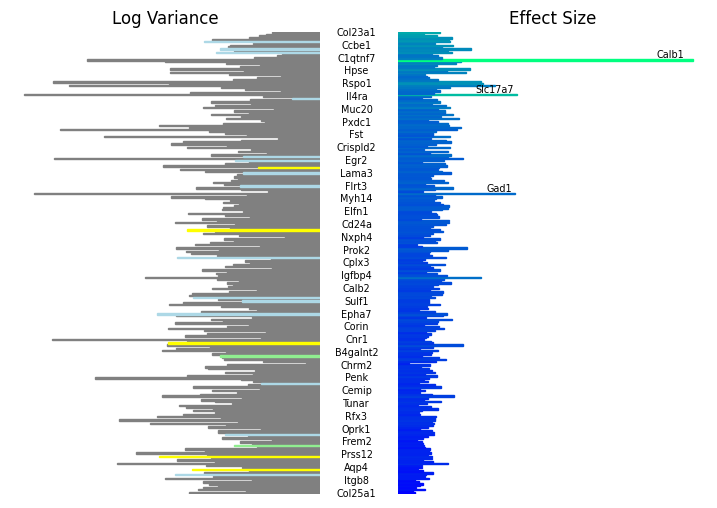

In [242]:
# Butterfly plot
# https://geoffruddock.com/notebooks/data-viz/butterfly-charts/
# sns.barplot(data=df, x='Gene', y='Effect Size')
y, x1, x2 = df['Gene'].to_numpy(), df['Variance'].to_numpy(), df['Effect Size'].to_numpy()
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(9, 6),
    subplot_kw={'yticks': []},
    gridspec_kw={'wspace': .25})
ax1.barh(y=y, width=x1, color='gray', edgecolor='gray')
ax1.invert_xaxis()
ax1.set_xscale('log')
ax1.set_title('Log Variance')

ax2.barh(y=y, width=x2, color='gray', edgecolor='gray')
ax2.set_title('Effect Size')

# Formatting
for ax in (ax1, ax2):
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_xticks([])  # Revise
    ax.margins(y=0)

# Labels
trans = mpltrans.blended_transform_factory(fig.transFigure, ax1.transData)
for i in range(len(y)-1, -1, -7):
    ax1.text(0.5+.01, i, y[i], fontsize='x-small', ha='center', va='center', transform=trans)
    # ax1.patches[i].set(facecolor='red', edgecolor='red', zorder=2.1)
for i, tlen in enumerate(df['Trajectory Length']):
    cmap = mpl.colormaps.get_cmap('winter')
    color = cmap((tlen-df['Trajectory Length'].min())/(df['Trajectory Length'].max()-df['Trajectory Length'].min()))
    ax2.patches[i].set(facecolor=color, edgecolor=color)
for i, gene in enumerate(y):
    npg = gene in gene_lists['Neuron Projection Guidance']
    nm = gene in gene_lists['Neuron Migration']
    color = None
    if npg and nm: color='lightgreen'
    elif npg: color='lightblue'
    elif nm: color='yellow'
    if color is not None:
        ax1.patches[i].set(facecolor=color, edgecolor=color, zorder=2.1)
for i in np.argsort(df['Effect Size'])[-3:]:
    ax2.text(.97*x2[i], i, df['Gene'].iloc[i], fontsize='x-small', ha='right', va='bottom', transform=ax2.transData)

fig.show()
# TODO: Add legends!


In [243]:
# Pin to data space (TODO: Training/val)
source_points = states[-1, :, :env.dim]
target_points = env.get_target_modalities()[0].cpu()
# Least-squares
A = np.hstack([source_points, np.ones((source_points.shape[0], 1))])
pinning_matrix = np.linalg.lstsq(A, target_points, rcond=None)[0].numpy()
# Pinning function
def pin_points(points):
    A = np.concatenate([points, np.ones((*points.shape[:-1], 1))], axis=-1)
    return np.dot(A, pinning_matrix)
# Get pinned states
# pin_points(states[:, :, :env.dim])


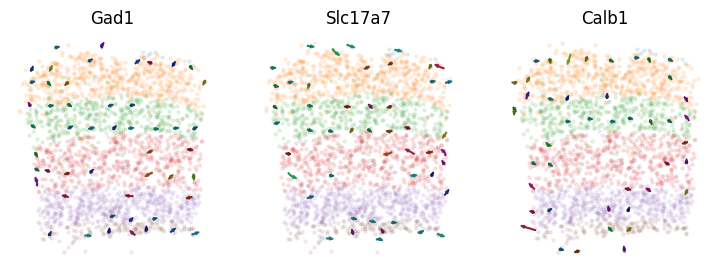

In [281]:
def plot_trajectory(source_states, *, ax):
    # Get pinned trajectories
    pinned_states = pin_points(source_states[:, :, :env.dim])  # Could add UMAP or PCA here

    # Take means by regions
    square_size = max([pinned_states[:, i].max()-pinned_states[:, i].min() for i in range(2)]) / 20.
    xs, ys = np.meshgrid(
        np.arange(pinned_states[:, :, 0].min(), pinned_states[:, :, 0].max(), square_size),
        np.arange(pinned_states[:, :, 1].min(), pinned_states[:, :, 1].max(), square_size))
    xs, ys = xs.flatten(), ys.flatten()
    mean_states = []
    for x, y in zip(xs, ys):
        state = pinned_states[0]
        bottom_left = np.array([x, y])
        top_right = bottom_left + square_size
        mask = (state >= bottom_left) * (state < top_right)
        mask = mask.prod(axis=-1).astype(bool)
        if mask.sum() > 0:
            mean_states.append(pinned_states[:, mask].mean(axis=1, keepdims=True))
    mean_states = np.concatenate(mean_states, axis=1)
    states_to_use = mean_states  # pinned_states

    # Plot original
    for l in np.unique(types):
        ax.scatter(*pinned_states[0, types==l].T, label=l, s=5, alpha=.1)

    # Get most interesting arrows
    total_movement = np.linalg.norm(states_to_use[1:] - states_to_use[:-1], ord=2, axis=-1).sum(axis=0)
    num_top = 50
    top_arrows = np.argsort(total_movement)[-num_top:]

    # Plot movement
    for i in top_arrows:
        # Filter to non-small movements
        threshold = 5e-3
        moving_pos_mask = []
        prev_pos = None
        for pos in states_to_use[:, i]:
            if prev_pos is None:
                moving_pos_mask.append(True)
                prev_pos = pos.copy()
                continue

            # Calculate dist
            dist = np.linalg.norm(pos - prev_pos, ord=2, axis=-1)

            # Record
            moving_pos_mask.append(dist > threshold)
            if moving_pos_mask[-1]: prev_pos = pos

        # Get moving states
        moving_states = states_to_use[moving_pos_mask, i]

        # Skip if too short
        if moving_states.shape[0] < 2: continue

        # Compute total movement
        start_pos = moving_states[0]
        end_pos = moving_states[-1]
        diff_pos = end_pos - start_pos
        r = (diff_pos**2).sum(axis=-1)**(1/2)
        theta = np.arctan2(diff_pos[1], diff_pos[0])
        # Aggregate colors
        hue = theta / (2*np.pi) + .5
        value = .4 + .2 * min(r / .1, 1.)
        saturation = .8
        color = colorsys.hsv_to_rgb(hue, saturation, value)

        # Plot lines
        ax.plot(*moving_states.T, color=color)

        # Plot arrow heads
        lookback_frames = max(int(.1*moving_states.shape[0]), 1)
        start_pos = moving_states[-(lookback_frames+1)]
        end_pos = moving_states[-1]
        diff_pos = end_pos - start_pos
        # origin = square_size * np.floor(start_pos / square_size) + square_size / 2
        ax.arrow(*start_pos, *diff_pos, width=0, head_width=.05, color=color)

    # Styling
    ax.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[])
    ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for gene, ax in zip(df.sort_values('Effect Size')['Gene'].iloc[-3:], axs):
    plot_trajectory(knocked_states[np.argwhere(df['Gene'] == gene)[0][0]], ax=ax)
    ax.set_title(gene)


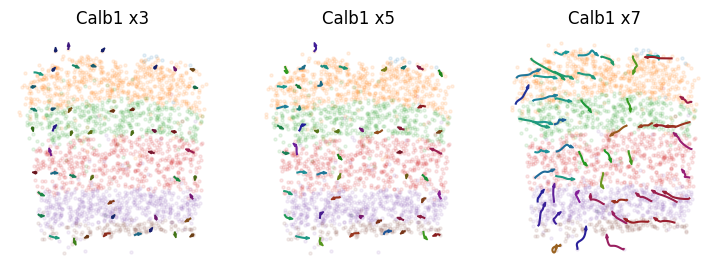

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, ax in zip((2, 5, 7), axs):
    feature_name = df.sort_values('Effect Size')['Gene'].iloc[-1]
    feature = np.argwhere(df['Gene'] == gene)[0][0]
    mult_knockdown_states = test_knockdown(modality_to_test, feature, factor=i)
    plot_trajectory(center_states(mult_knockdown_states), ax=ax)
    ax.set_title(f'{feature_name} x{i}')


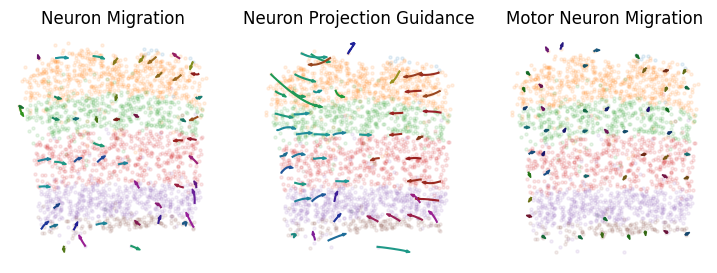

In [247]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for gene_list_key, ax in zip(gene_lists, axs):
    features = np.argwhere(env.dataloader.get_transformables()[2][modality_to_test].index.isin(gene_lists[gene_list_key])).flatten()
    list_knockdown_states = test_knockdown(modality_to_test, features)
    plot_trajectory(center_states(list_knockdown_states), ax=ax)
    ax.set_title(gene_list_key)
